### 0. 함수 import

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.signal import medfilt
import lightgbm as lgb
from sklearn.model_selection import train_test_split # 간단한 분리 또는 시간 기반 분리 필요

In [2]:
font_name = 'Malgun Gothic'
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

### 1-1. df 시계열 데이터 불러오기

In [3]:
# 이 부분은 changable. 데이터를 불러오는 단계
folder_path = './farm_data'  # CSV 파일이 있는 폴더 경로
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
dataframes = []
for f in csv_files:
    file_path = os.path.join(folder_path, f)
    try:
        # CSV 파일을 읽어올 때, 8번째와 16번째 열을 float로 지정
        df_temp = pd.read_csv(file_path, dtype={8: float, 16: float})
    except Exception as e:
        print(f"Error reading {file_path}: {e} (assuming error value (over 1,000mg/L DO))")
        continue
    dataframes.append(df_temp)

df = pd.concat(dataframes, ignore_index=True)

Error reading ./farm_data\page-01.csv: could not convert string to float: '1,086.7' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-02.csv: could not convert string to float: '1,094.6' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-03.csv: could not convert string to float: '1,024.2' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-04.csv: could not convert string to float: '1,127.6' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-05.csv: could not convert string to float: '1,170.3' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-06.csv: could not convert string to float: '1,029' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-07.csv: could not convert string to float: '1,108.6' (assuming error value (over 1,000mg/L DO))
Error reading ./farm_data\page-08.csv: could not convert string to float: '1,084.4' (assuming error value (over 1

### 1-2. 데이터 기본 구조 및 통계량 확인 (결측치, 이상치 등 개요 파악)

In [4]:
#print(df.info())
#print(df.describe())
#print("결측치 개수:\n", df.isnull().sum())

### 1-3. column 제거 및 시간 통합 (일시로)

In [5]:
# df에서 지역명, 양식장 이름, 시설 이름, 시설 ID를 추출하여 dictionary 생성
facility_id_dict = {}
for index, row in df.iterrows():
    region = row['지역명']
    farm_name = row['양식장 이름']
    facility_name = row['시설 이름']
    facility_id = row['시설 ID']
    facility_names = f"{region} {farm_name} {facility_name.replace(' ', '')}"
    
    if facility_id in facility_id_dict:
        if facility_id_dict[facility_id] != facility_names:
            print(f"시설 ID {facility_id}의 이름이 다릅니다: {facility_id_dict[facility_id]} vs {facility_names}")
    else:
        facility_id_dict[facility_id] = facility_names
# df에서 일자와 시간을 합쳐서 datetime 형식으로 변환 후 일시라는 항목으로 저장
df['일시'] = pd.to_datetime(df['일자'].astype(str) + ' ' + df['시간'].astype(str), format='%Y-%m-%d %H:%M:%S', errors='coerce')
# 미사용 column 제거
df = df.drop(columns=['일자','시간','지역명','양식장 이름','시설 이름','양식장 ID','지역코드','유입수 탁도(fnu)', '유량1(m3/h)','유량2(m3/h)','유량3(m3/h)', 'ORP(mV)', '전압', '전력', 'RPM', '주파수'], errors='ignore')

In [6]:
# 시설 ID, 수온, 일시 세가지 column으로 구성된 df 생성
temper_df = df[['시설 ID', '수온(℃)', '일시']].copy()
temper_df.loc[:, '일시'] = pd.to_datetime(temper_df['일시'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

### 1-4. 리샘플링(결측치 찾기 위해)

In [7]:
resampling_period = '1h' # '1h'도 가능
sampled_df = pd.DataFrame()
for fi in facility_id_dict.keys():
    select_df = temper_df[temper_df['시설 ID'] == fi]
    select_df = select_df.sort_values(by='일시')
    column_name = '수온(℃)'

    # 1. '일시' 컬럼을 인덱스로 설정
    select_df.set_index('일시', inplace=True)
    # 이제 select_df의 인덱스는 '일시' 컬럼의 datetime 값들입니다.
    # 이 인덱스의 이름도 '일시'가 됩니다.

    # 2. 수온 컬럼을 포함하여 리샘플링
    df_resampled = select_df.resample(resampling_period).agg({
        '수온(℃)': 'mean'
    })

    # 3. df_resampled의 시간 인덱스를 다시 '일시' 컬럼으로 만들기 <--- 이 부분이 추가/수정되어야 합니다.
    df_resampled.reset_index(inplace=True)

    df_resampled['시설 ID'] = fi
    
    sampled_df = pd.concat([sampled_df, df_resampled], ignore_index=True)

### 1-4-2. 임계값 데이터 제거

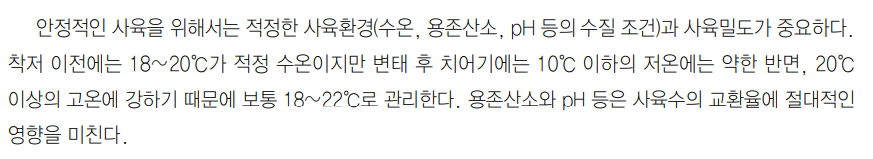

In [8]:
temp_min = 0 #임계없음
temp_min = 17 #적정 수온 18~22도를 기준. 최저수온 18 -1도
temp_min = 10 #(이 값은 임계값)

temp_max = 50 #임계없음
temp_max = 23 #적정 수온 18~22도를 기준. 최고수온 22 +1도 
temp_max = 27 #(이 값은 임계값)

condition = (sampled_df['수온(℃)'] <= temp_min) | (sampled_df['수온(℃)'] >= temp_max)

# 2. .loc를 사용하여 조건에 맞는 행의 '수온(℃)' 컬럼 값을 np.nan으로 변경
sampled_df.loc[condition, '수온(℃)'] = np.nan

### 1-4-3. SPIKE 제거

In [9]:
for fi in facility_id_dict.keys():
    final_extracted_list = sampled_df[sampled_df['시설 ID'] == fi][['수온(℃)', '일시']].values.tolist()
    # 1. y값과 x값(시간) 추출
    y_values_orig = np.array([item[0] for item in final_extracted_list], dtype=float)
    x_values_orig_dt = [item[1] for item in final_extracted_list] # datetime 객체 리스트

    if len(y_values_orig) < 2:
        print("Δy를 계산하려면 최소 2개의 y값이 필요합니다.")
        # 이 경우 아래 로직 실행 안 함
    else:
        delta_y = np.diff(y_values_orig)
        x_values_for_delta_y = x_values_orig_dt[1:] # Δy에 대한 x축 값

        lower_threshold, upper_threshold = -np.inf, np.inf # 기본값
        anomalous_dy_indices = np.array([]) # 기본값

        if len(delta_y) == 0:
            print("Δy 배열이 비어있어 임계값을 계산할 수 없습니다.")
        else:
            delta_y_no_nan = delta_y[~np.isnan(delta_y)]
            if len(delta_y_no_nan) < 2:
                print("Δy 배열에서 NaN을 제외한 유효 데이터가 부족하여 IQR 임계값을 계산할 수 없습니다.")
            else:
                Q1 = np.percentile(delta_y_no_nan, 25)
                Q3 = np.percentile(delta_y_no_nan, 75)
                IQR = Q3 - Q1
                iqr_multiplier = 1.5 # 민감도 조절 변수
                lower_threshold = Q1 - iqr_multiplier * IQR
                upper_threshold = Q3 + iqr_multiplier * IQR
                
                print("--- 자동 임계값 계산 결과 (IQR 방식) ---")
                print(f"  (NaN이 아닌 Δy 값 {len(delta_y_no_nan)}개로 계산)")
                print(f"  Δy - Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
                print(f"  하한 임계값: {lower_threshold:.3f}, 상한 임계값: {upper_threshold:.3f}")

                anomalous_dy_indices = np.where((delta_y < lower_threshold) | (delta_y > upper_threshold))[0]
                print(f"\n자동 임계값을 벗어난 Δy 개수: {len(anomalous_dy_indices)}")

        # 스파이크로 식별된 원본 y_values_orig의 인덱스
        identified_y_spike_indices = []
        if len(delta_y) > 1: # Δy가 최소 2개는 있어야 연속된 두 개의 Δy를 비교 가능
            for i in range(len(delta_y) - 1):
                if np.isnan(delta_y[i]) or np.isnan(delta_y[i+1]): # NaN 값 건너뛰기
                    continue
                current_dy_is_outlier = (delta_y[i] < lower_threshold) or (delta_y[i] > upper_threshold)
                next_dy_is_outlier = (delta_y[i+1] < lower_threshold) or (delta_y[i+1] > upper_threshold)
                if current_dy_is_outlier and next_dy_is_outlier and (np.sign(delta_y[i]) * np.sign(delta_y[i+1]) == -1):
                    spike_candidate_index = i + 1
                    identified_y_spike_indices.append(spike_candidate_index)
        identified_y_spike_indices = sorted(list(set(identified_y_spike_indices)))
        print(f"\n스파이크로 식별되어 NaN 처리될 y_values_orig의 인덱스: {identified_y_spike_indices}")
        

        # 원본 y 데이터에서 이상치 처리 (NaN으로 변경)
        y_values_cleaned = np.copy(y_values_orig)
        for idx in identified_y_spike_indices:
            if 0 <= idx < len(y_values_cleaned):
                y_values_cleaned[idx] = np.nan
        
        condition = (sampled_df['시설 ID'] == fi)
        sampled_df.loc[condition, '수온(℃)'] = y_values_cleaned

--- 자동 임계값 계산 결과 (IQR 방식) ---
  (NaN이 아닌 Δy 값 8065개로 계산)
  Δy - Q1: -0.033, Q3: 0.000, IQR: 0.033
  하한 임계값: -0.083, 상한 임계값: 0.050

자동 임계값을 벗어난 Δy 개수: 3248

스파이크로 식별되어 NaN 처리될 y_values_orig의 인덱스: [19, 84, 100, 154, 451, 452, 476, 505, 527, 909, 976, 1006, 1033, 1222, 1291, 1292, 1506, 1605, 1648, 1746, 1747, 2181, 2439, 2440, 2589, 2636, 2638, 2641, 2642, 2794, 2823, 2824, 2952, 2967, 2976, 3071, 3164, 3181, 3289, 3290, 3308, 3375, 3384, 3400, 3485, 3486, 3519, 3523, 3589, 3590, 3687, 3711, 3976, 3996, 4097, 4287, 4288, 4289, 4313, 4489, 4490, 4502, 4704, 4888, 4893, 4937, 5107, 5108, 5141, 5376, 5377, 5426, 5429, 5437, 5493, 5594, 5595, 5603, 5628, 7704, 7824, 7850, 7885, 7941, 7942, 7968, 7986, 8064, 8136, 8173, 8222, 8255, 8274, 8353, 8477, 8539, 8552, 8655, 8689, 8690, 8703, 8760, 8808, 8838, 9021, 9023, 9035, 9038, 9052, 9061, 9084, 9085, 9105, 9131, 9135, 9136, 9339, 9358, 9379, 9386, 9470, 9513, 9518, 9532, 9537, 9542, 9551, 9558, 9603, 9620, 9624, 9640, 9641, 9670, 9691, 9738, 9

### 1-5-1. 중앙값 필터링

In [10]:
# --- 중앙값 필터 적용 ---
# kernel_size는 필터 윈도우의 크기를 의미하며, 반드시 홀수여야 합니다.
# 이 값은 데이터의 특성과 제거하려는 스파이크의 폭에 따라 조정해야 합니다.
# 작은 값(예: 3, 5)은 짧은 스파이크를 제거하고, 큰 값은 더 많이 평탄화합니다.
kernel_s = 5 # 예시로 5를 사용 (데이터 포인트 5개 기준 중앙값)

for fi in facility_id_dict.keys():
    target_df = sampled_df[sampled_df['시설 ID'] == fi].copy()
    original_y_values = target_df['수온(℃)'].values
    filtered_y_values = medfilt(original_y_values, kernel_size=kernel_s)
    sampled_df.loc[sampled_df['시설 ID'] == fi, 'temp_median(℃)'] = filtered_y_values
    """
    # --- 결과 시각화 ---
    plt.figure(figsize=(15, 7))

    # 원본 데이터 플롯
    plt.plot(target_df['일시'], target_df['수온(℃)'], label='original temp(y)', marker='.', linestyle='-', color='lightcoral', alpha=0.7)

    # 중앙값 필터 적용된 데이터 플롯
    plt.plot(target_df['일시'], target_df['temp_median(℃)'], label=f'median filtered temp(y) (kernel_size={kernel_s})', marker='.', linestyle='-', color='royalblue')

    plt.title(f'facil ID: {fi} - original vs median filtered', fontsize=16) # fi 변수 사용 시
    # plt.title('원본 수온 vs 중앙값 필터 적용 수온', fontsize=16) # fi 변수 미사용 시
    plt.xlabel('date', fontsize=12)
    plt.ylabel('water temperature (℃)', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # x축 시간 포맷 설정 (데이터가 많을 경우 유용)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gcf().autofmt_xdate() # x축 레이블이 겹치지 않도록 자동 조정

    plt.tight_layout()
    plt.show()
    """

In [11]:
jeju_water_farms = {
    '64AF2': 22187,  # 제주, 바다드림
    '64AF1': 22187,  # 제주, 비봉수산
    '64AF3': 22304   # 제주, 산양수산
}


### 1-5-2. 지수 평균 이동 적용

In [12]:

median_filtered_column_name = f'수온(℃)'
ema_span = 24 # 예시 span 값, 데이터에 맞게 조정 필요
nan_stretch_threshold = 7
try:
    df_from_pickle = pd.read_pickle('jeju_data/pickle/jeju_water_temperature.pkl')
    print("\n✅ pickle 파일 'water_temperature.pkl'을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print("\n⚠️ 경고: 'water_temperature.pkl' 파일을 찾을 수 없습니다. pickle 데이터는 그래프에 표시되지 않습니다.")
    df_from_pickle = None



✅ pickle 파일 'water_temperature.pkl'을 성공적으로 불러왔습니다.


In [13]:
# --- 사용자 설정 변수 ---
median_filtered_column_name = '수온(℃)' # 원본 데이터 컬럼명
ema_span = 24  # EMA 계산 시 span 값
nan_stretch_threshold = 7 # 긴 NaN 구간으로 판단할 연속 NaN의 최소 길이

# 예측 관련 설정
prediction_lags = range(1, 8) # 예측에 사용할 과거 lag 범위 (예: 과거 7일치 EMA 값)
test_size_ratio = 0.2 # 테스트 데이터 비율 (예: 마지막 20%)
predict_ahead_steps = 5 # 얼마나 먼 미래를 예측할 것인가 (참고: 현재 코드는 다음 스텝 예측 위주)

In [14]:
def create_lagged_features_for_prediction(df, target_col, lags):
    """
    예측 모델을 위한 lagged features 생성.
    NaN 값을 포함할 수 있으며, LightGBM이 이를 처리합니다.
    """
    pdf = df.copy()
    for lag in lags:
        pdf[f'{target_col}_lag_{lag}'] = pdf[target_col].shift(lag)
    return pdf

# ======================================================================================================


--- 제주 바다드림영어조합법인 수조17 (64AF2-RT2)의 데이터 처리 시작 ---
[64AF2-RT2] 학습 데이터: 15704, 테스트 데이터: 3926
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 15704, number of used features: 7
[LightGBM] [Info] Start training from score 18.632465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 15704, number of used features: 7
[LightGBM] [Info] Start training from score 16.091671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

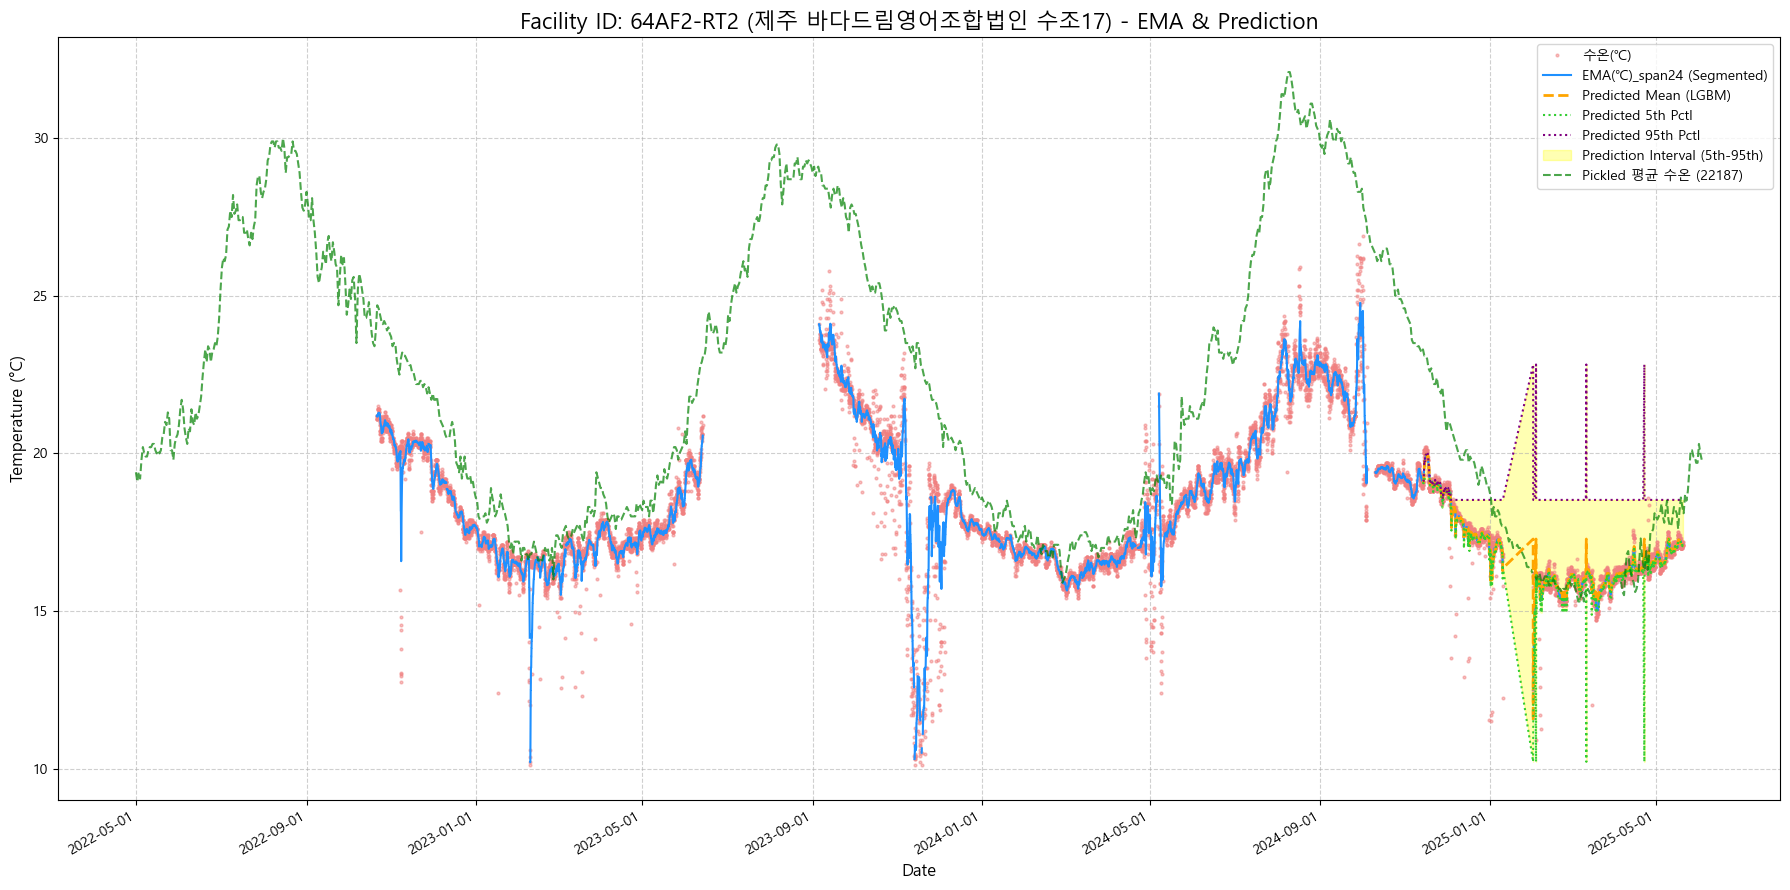


--- 완도 신호수산 수조A6 (61AF3-RT1)의 데이터 처리 시작 ---
[61AF3-RT1] 학습 데이터: 13173, 테스트 데이터: 3294
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13173, number of used features: 7
[LightGBM] [Info] Start training from score 16.528697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13173, number of used features: 7
[LightGBM] [Info] Start training from score 10.589954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

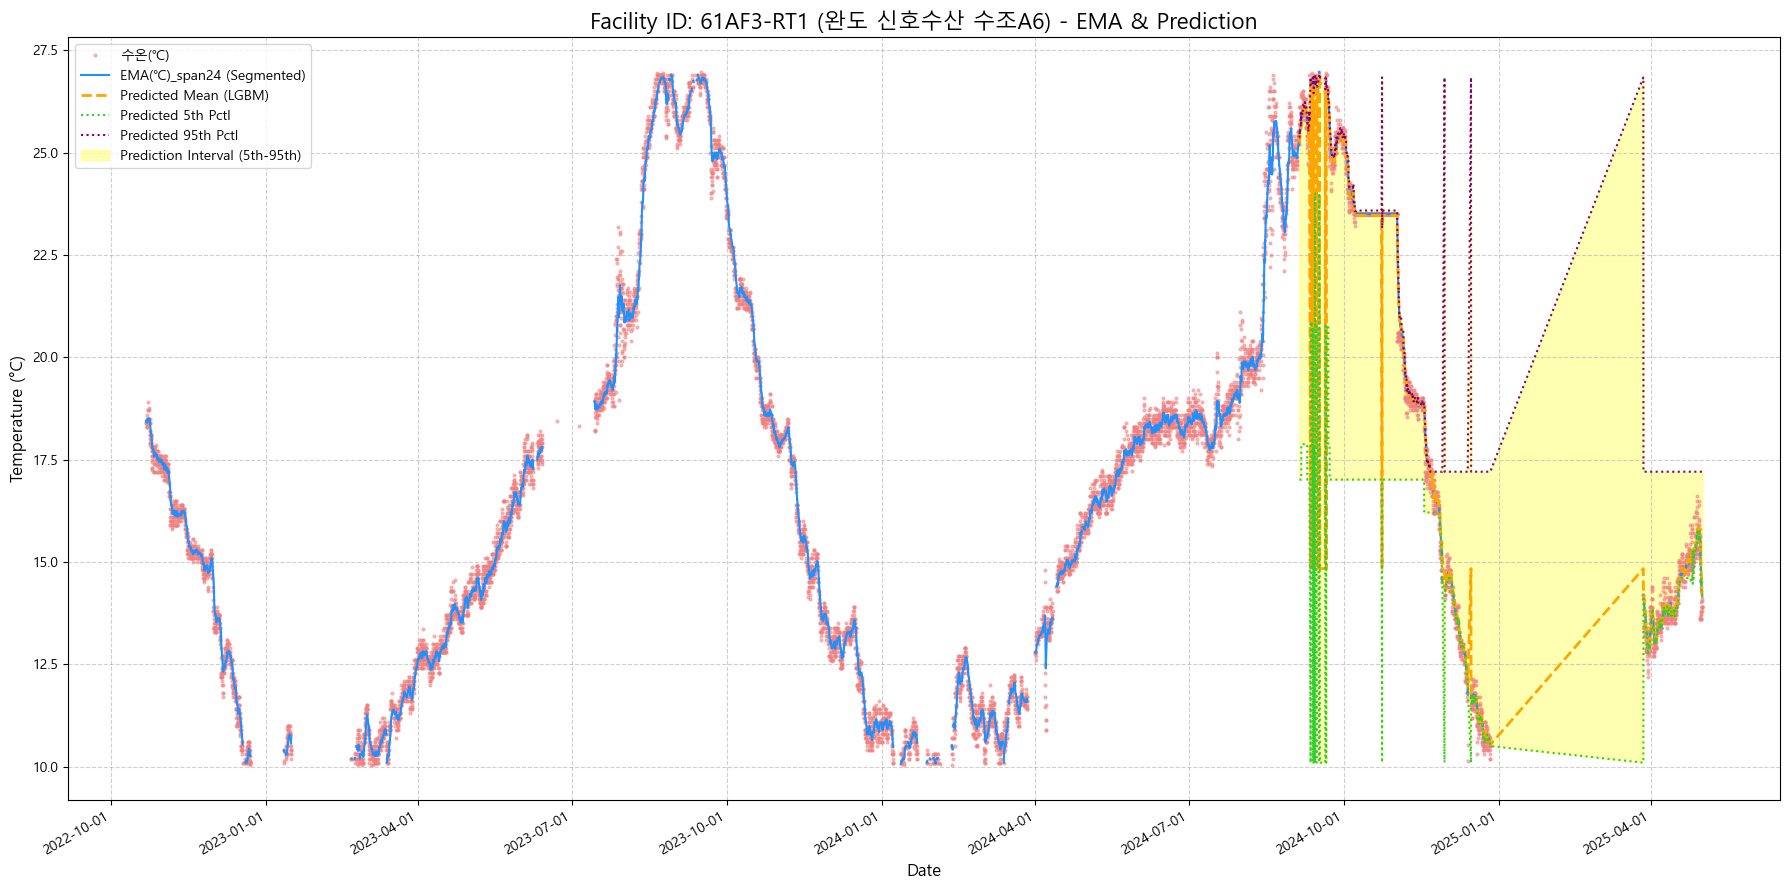


--- 제주 비봉수산 유입수 (64AF1-IW1)의 데이터 처리 시작 ---
[64AF1-IW1] 학습 데이터: 16620, 테스트 데이터: 4156
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 16620, number of used features: 7
[LightGBM] [Info] Start training from score 19.925791
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 16620, number of used features: 7
[LightGBM] [Info] Start training from score 17.179142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

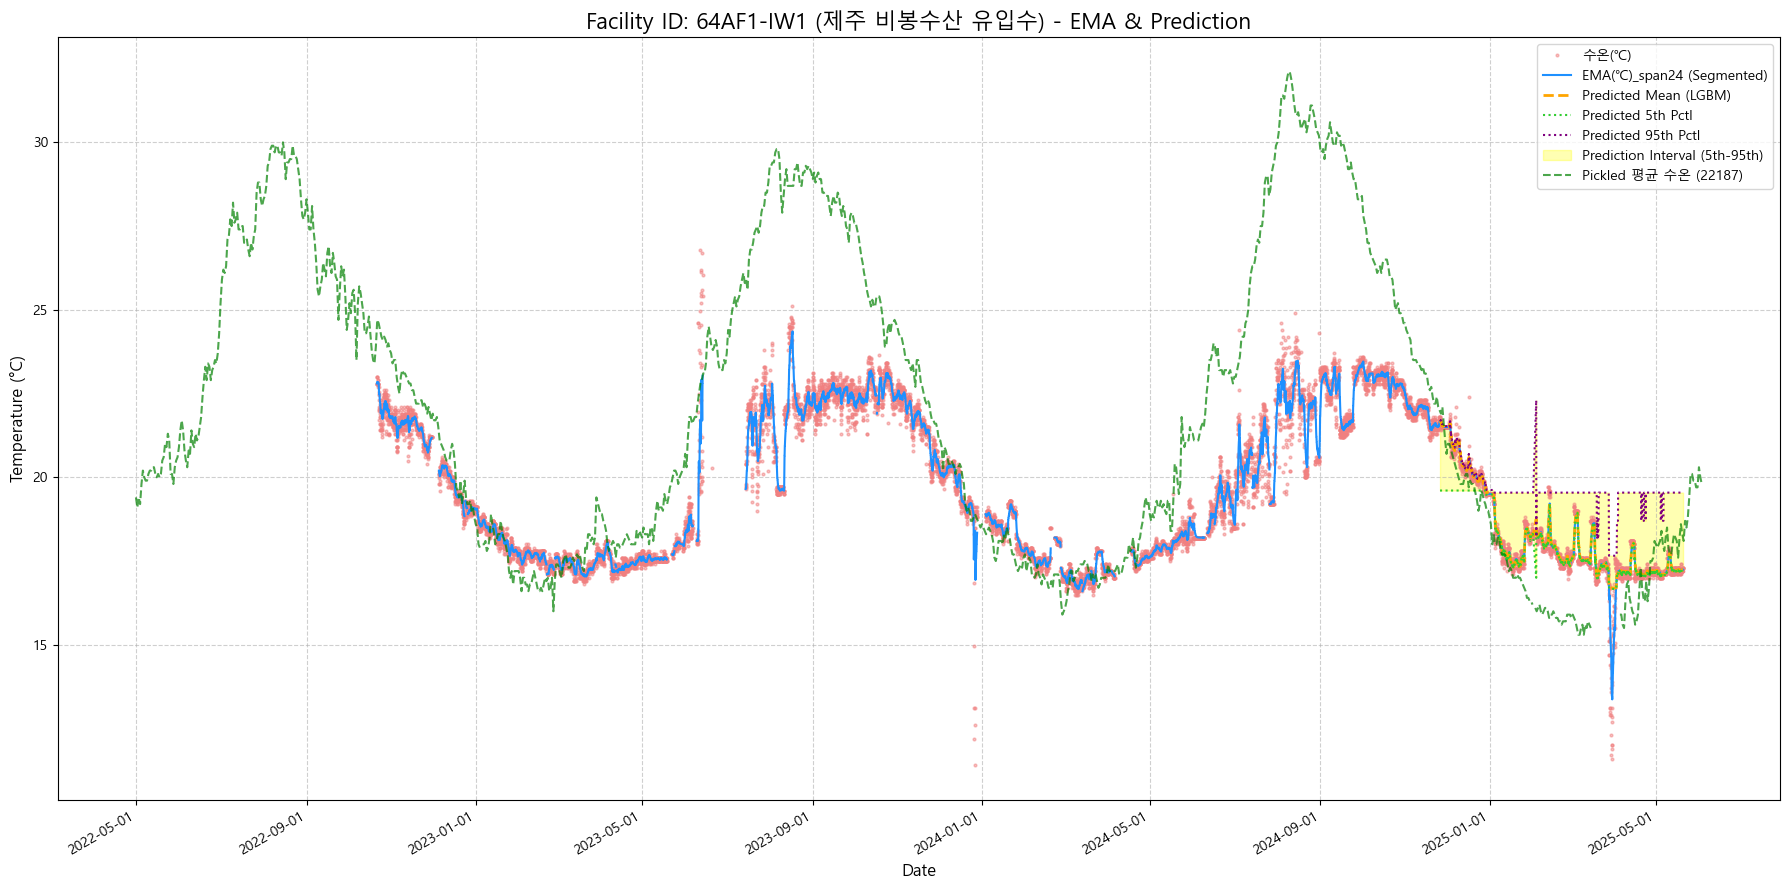


--- 해남 정우수산 수조2 (65AF1-RT2)의 데이터 처리 시작 ---
[65AF1-RT2] 학습 데이터: 4227, 테스트 데이터: 1057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 4227, number of used features: 7
[LightGBM] [Info] Start training from score 20.676175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 4227, number of used features: 7
[LightGBM] [Info] Start training from score 11.520267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

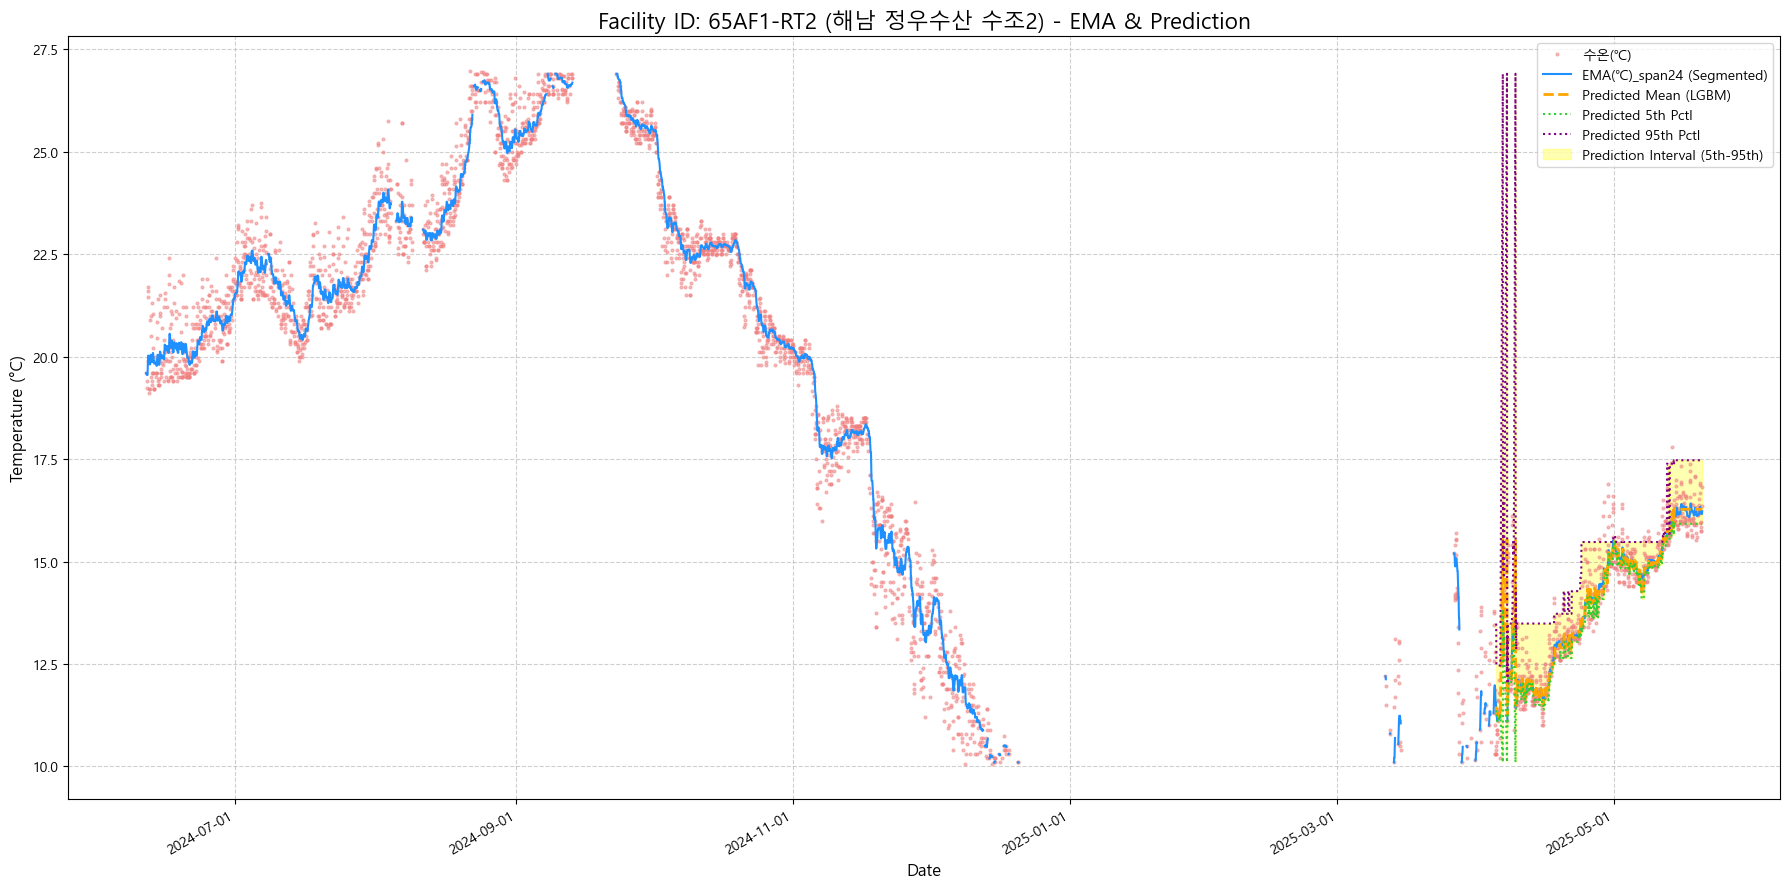


--- 제주 바다드림영어조합법인 수조13 (64AF2-RT1)의 데이터 처리 시작 ---
[64AF2-RT1] 학습 데이터: 15716, 테스트 데이터: 3930
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 15716, number of used features: 7
[LightGBM] [Info] Start training from score 18.477876
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 15716, number of used features: 7
[LightGBM] [Info] Start training from score 15.925628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

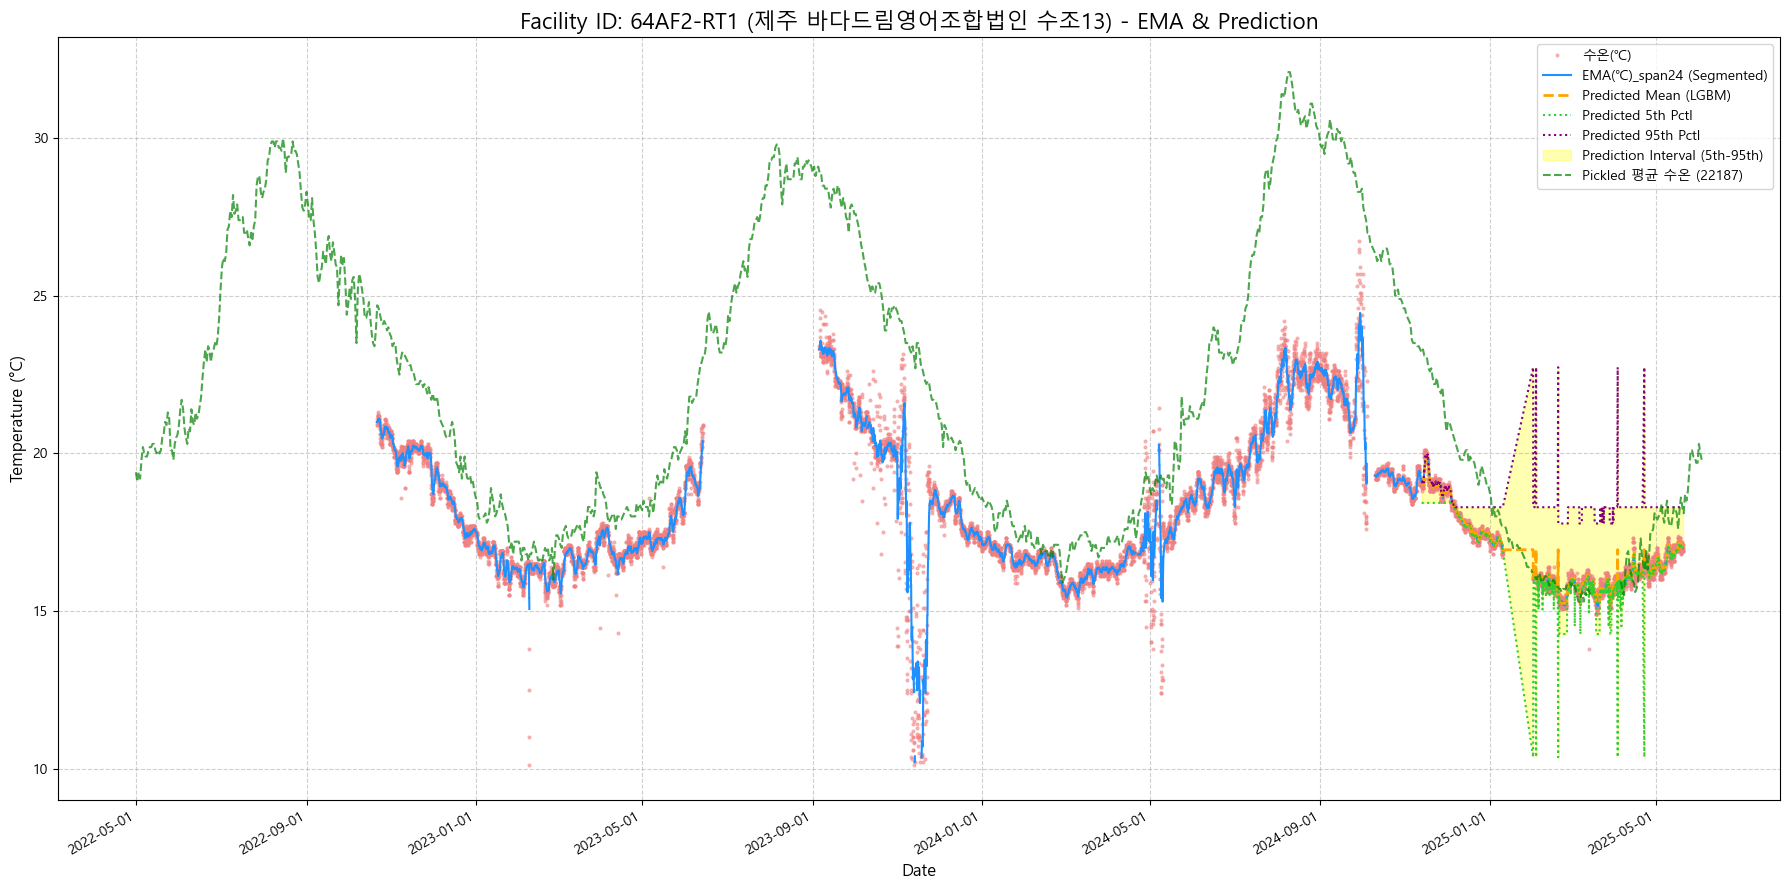


--- 제주 신양수산 수조D4 (64AF3-RT2)의 데이터 처리 시작 ---
[64AF3-RT2] 학습 데이터: 14173, 테스트 데이터: 3544
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14173, number of used features: 7
[LightGBM] [Info] Start training from score 18.422009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14173, number of used features: 7
[LightGBM] [Info] Start training from score 16.600000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data p

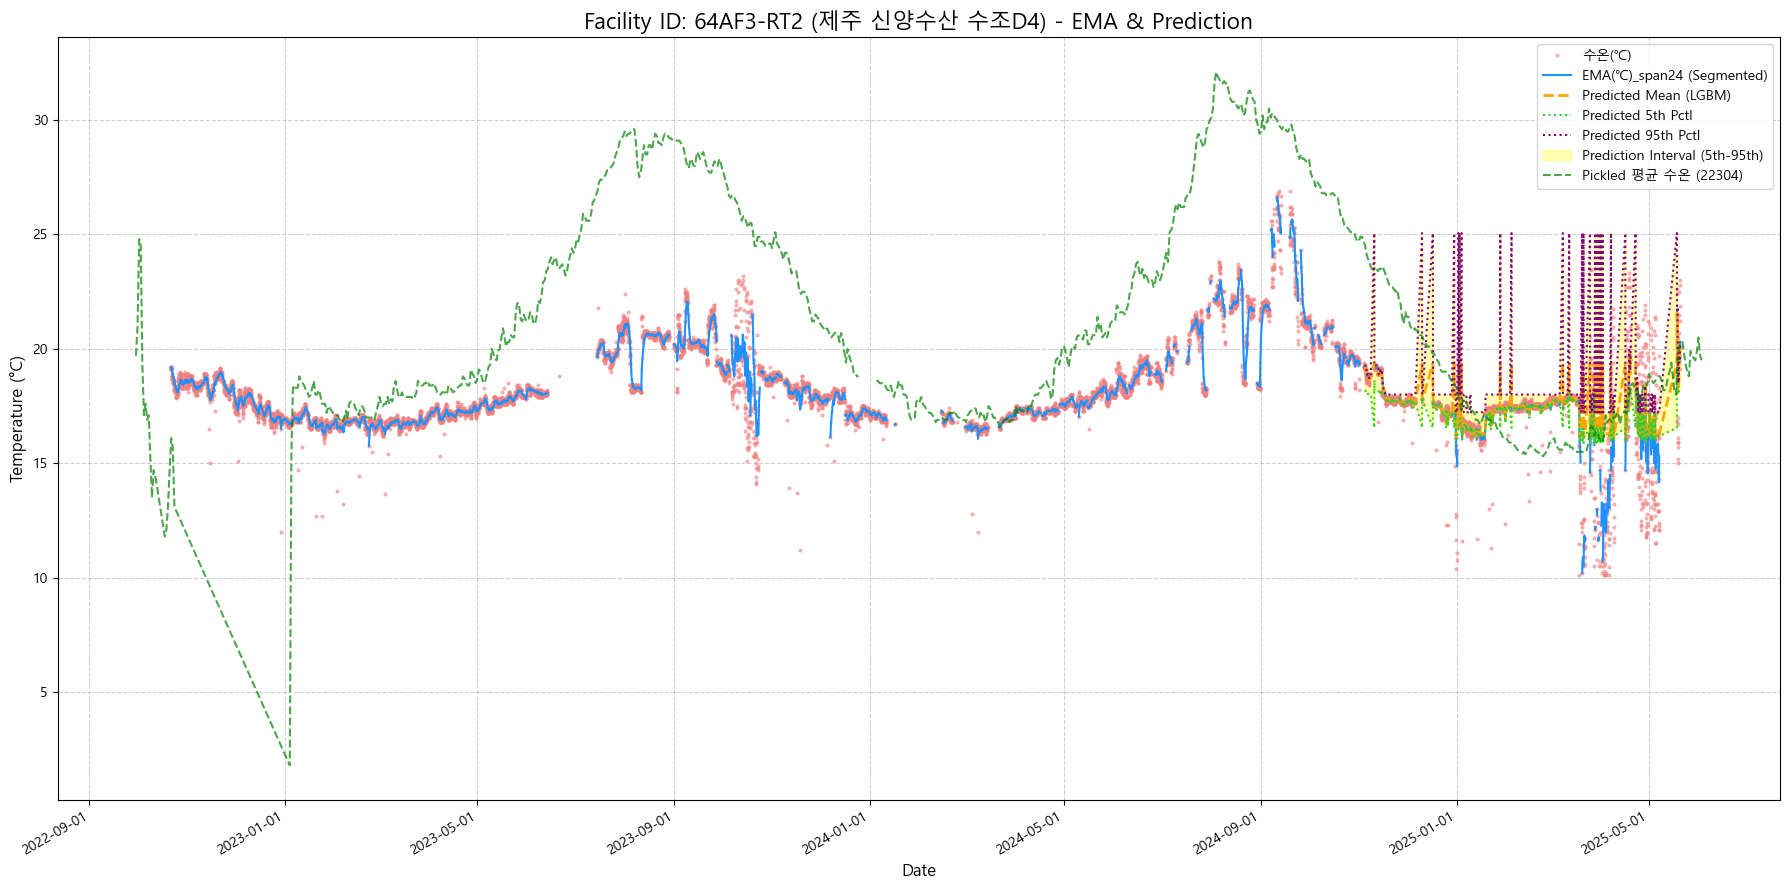


--- 제주 신양수산 수조C2 (64AF3-RT1)의 데이터 처리 시작 ---
[64AF3-RT1] 학습 데이터: 13226, 테스트 데이터: 3307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13226, number of used features: 7
[LightGBM] [Info] Start training from score 18.338494
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13226, number of used features: 7
[LightGBM] [Info] Start training from score 16.155712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

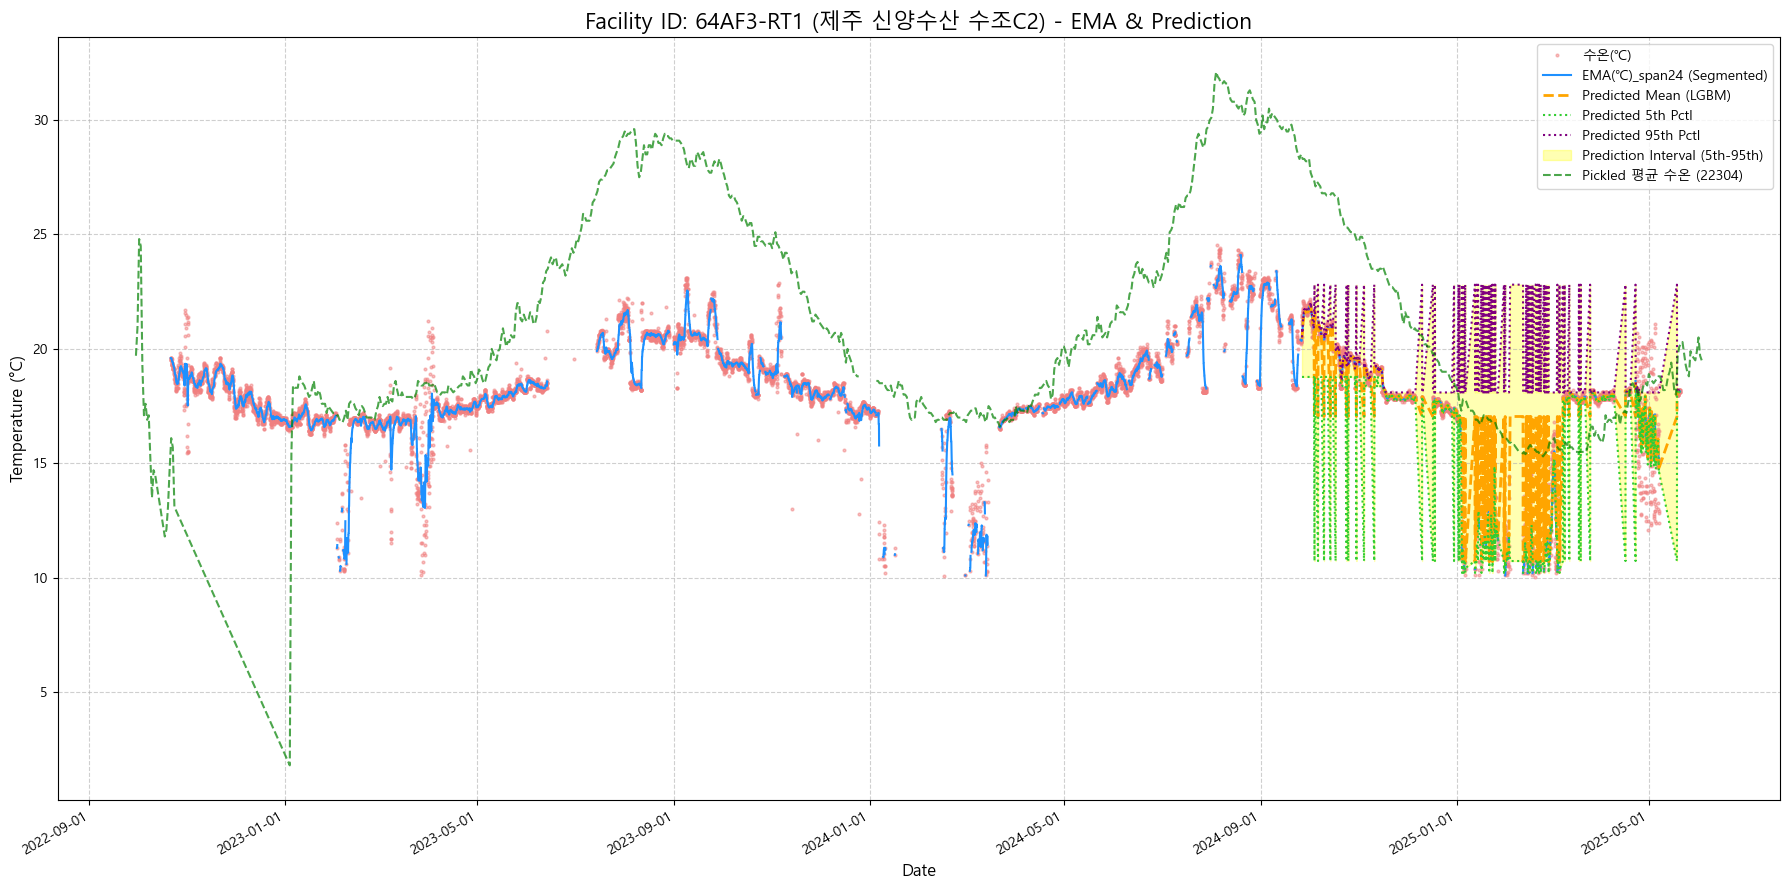


--- 해남 정우수산 수조3 (65AF1-RT3)의 데이터 처리 시작 ---
[65AF1-RT3] 학습 데이터: 4204, 테스트 데이터: 1051
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 4204, number of used features: 7
[LightGBM] [Info] Start training from score 20.760288
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 4204, number of used features: 7
[LightGBM] [Info] Start training from score 11.467035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

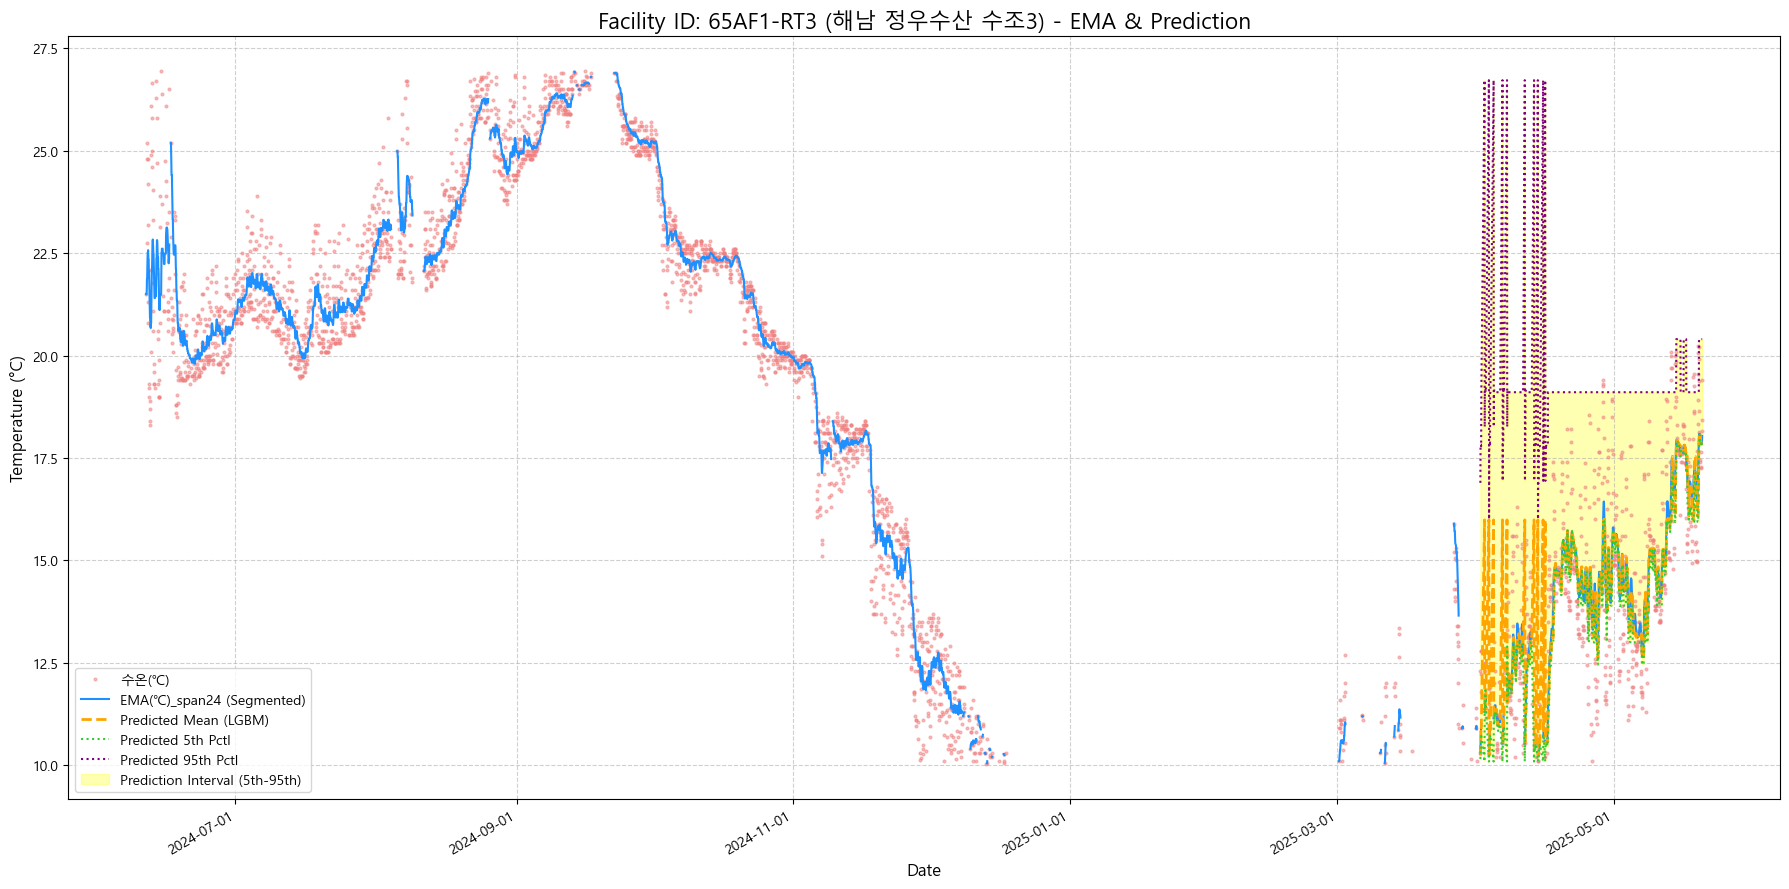


--- 완도 신호수산 수조A7 (61AF3-RT2)의 데이터 처리 시작 ---
[61AF3-RT2] 학습 데이터: 13172, 테스트 데이터: 3293
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13172, number of used features: 7
[LightGBM] [Info] Start training from score 16.527530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 13172, number of used features: 7
[LightGBM] [Info] Start training from score 10.627064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

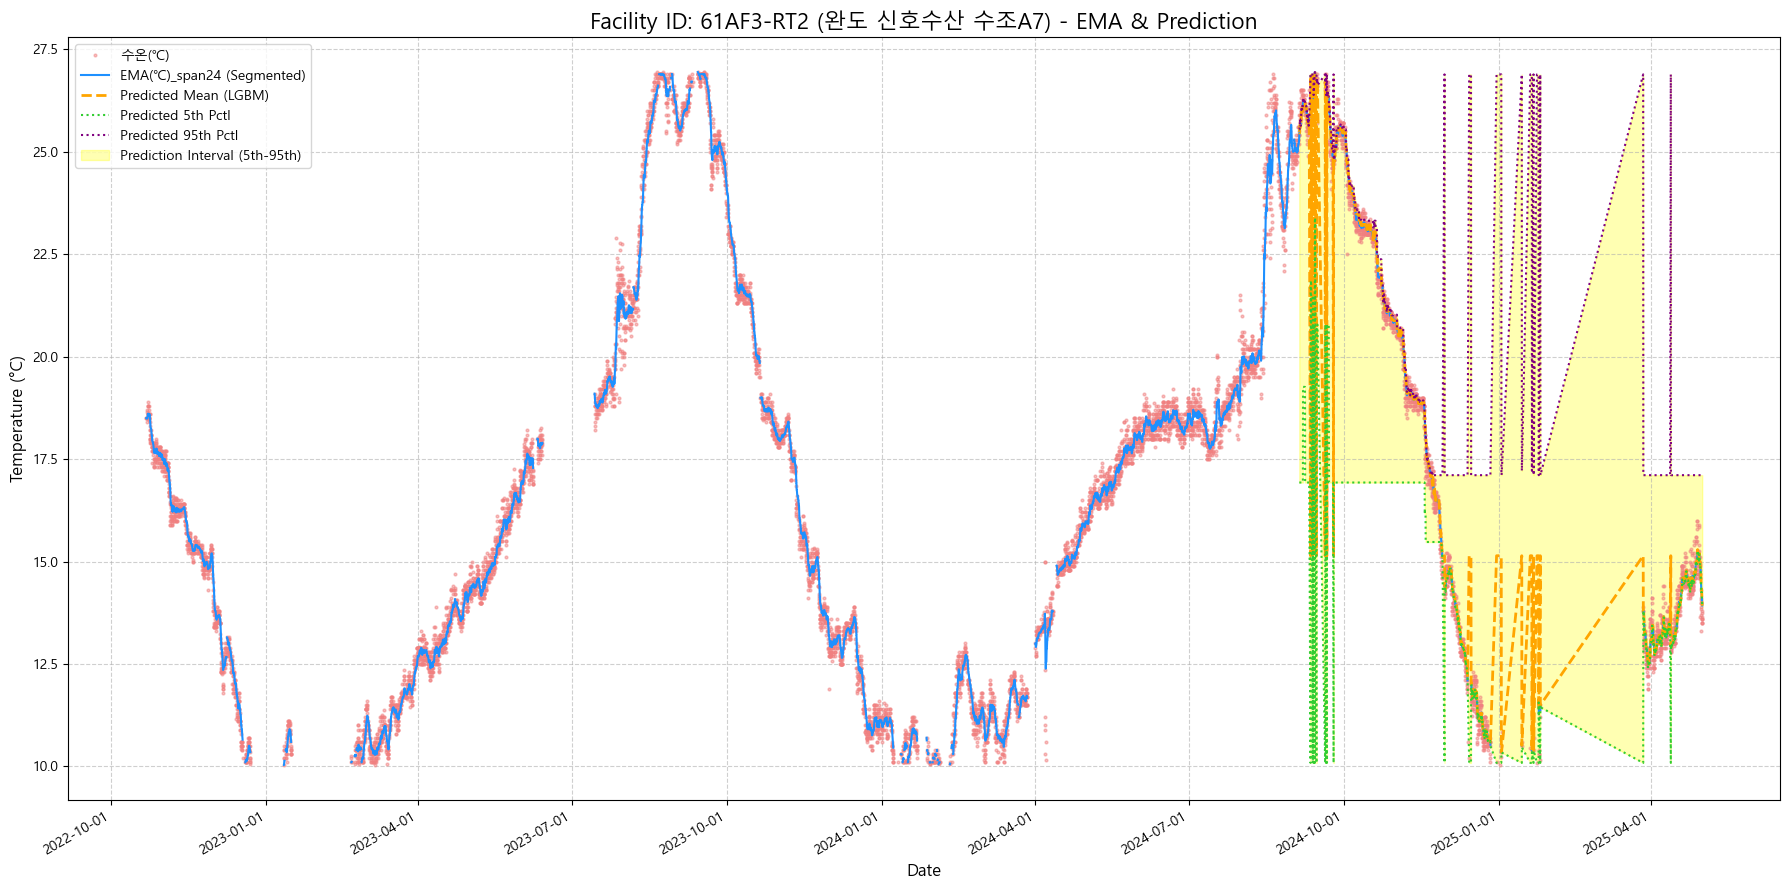


--- 제주 신양수산 유입수 (64AF3-IW1)의 데이터 처리 시작 ---
[64AF3-IW1] 학습 데이터: 14079, 테스트 데이터: 3520
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14079, number of used features: 7
[LightGBM] [Info] Start training from score 18.702186
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14079, number of used features: 7
[LightGBM] [Info] Start training from score 15.760258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

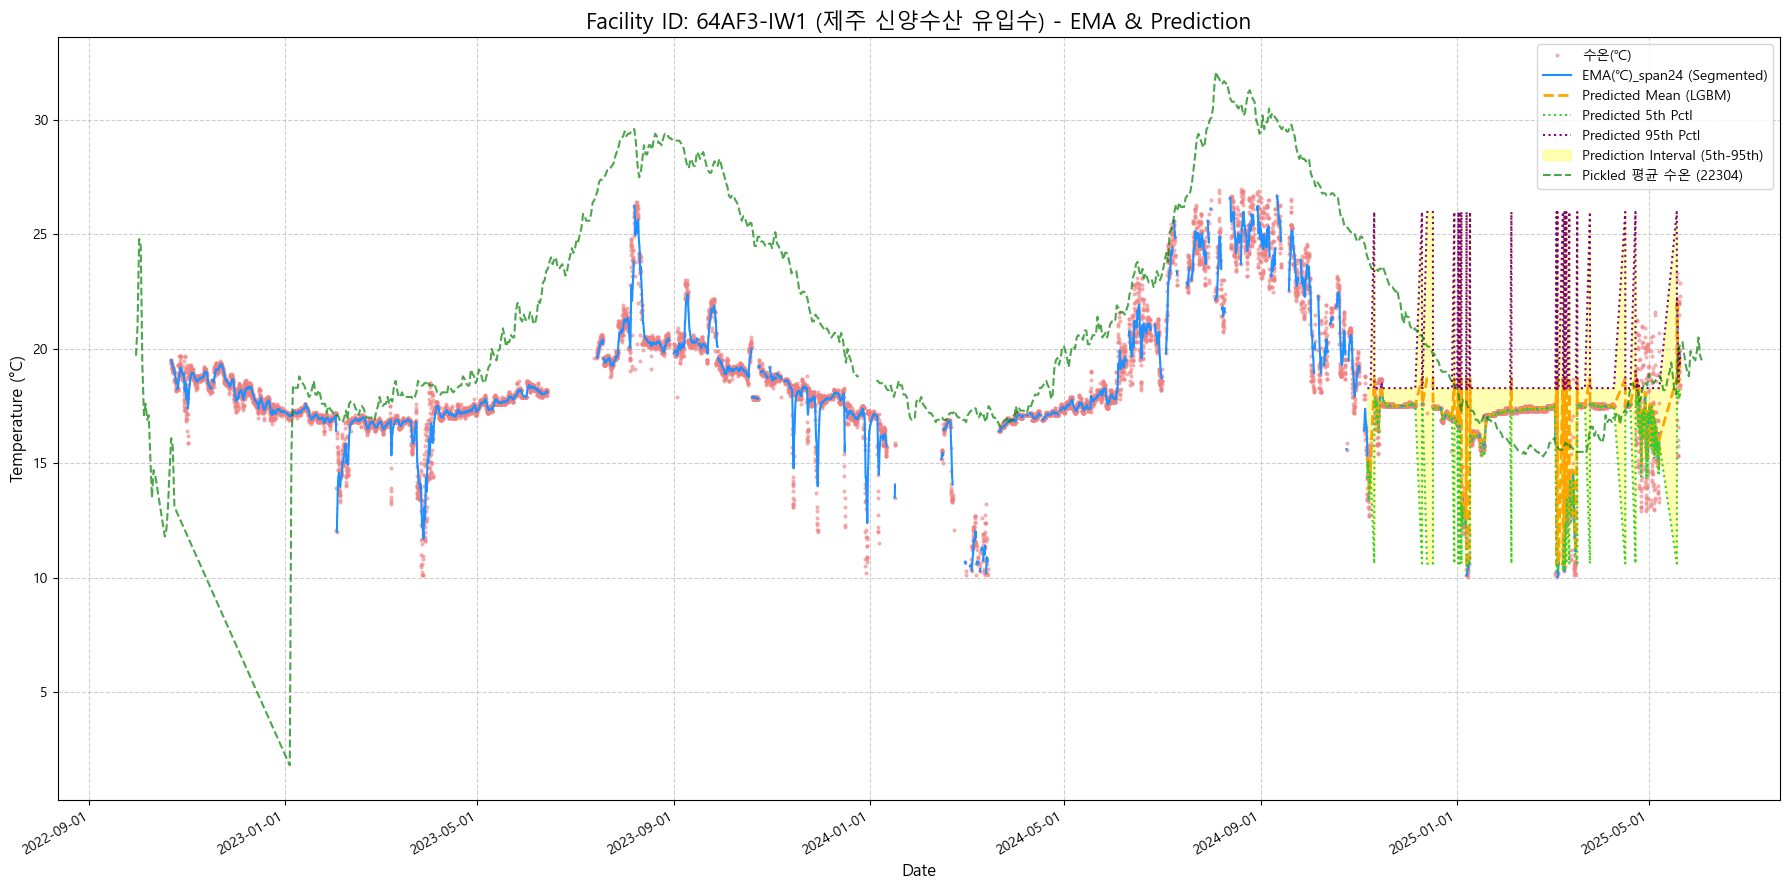


--- 완도 신호수산 유입수 (61AF3-IW1)의 데이터 처리 시작 ---
[61AF3-IW1] 학습 데이터: 11546, 테스트 데이터: 2887
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 11546, number of used features: 7
[LightGBM] [Info] Start training from score 17.722659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 11546, number of used features: 7
[LightGBM] [Info] Start training from score 11.216183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

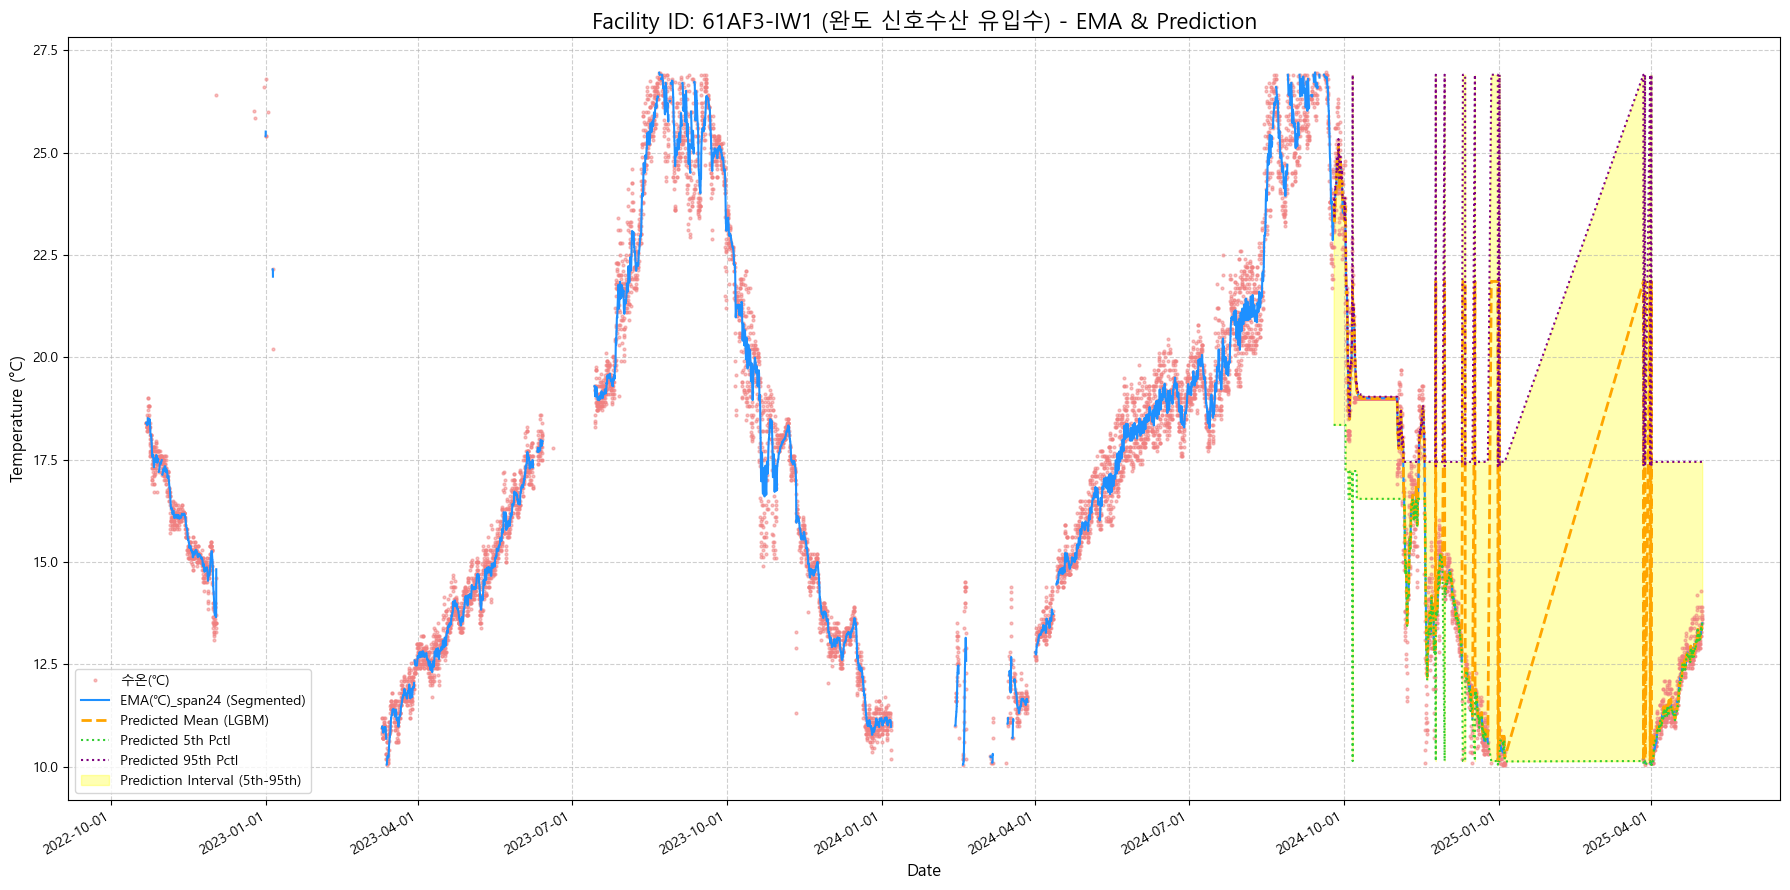


--- 해남 정우수산 유입수 (65AF1-IW1)의 데이터 처리 시작 ---
[65AF1-IW1] 학습 데이터: 4194, 테스트 데이터: 1049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4194, number of used features: 7
[LightGBM] [Info] Start training from score 20.699318
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4194, number of used features: 7
[LightGBM] [Info] Start training from score 11.459177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

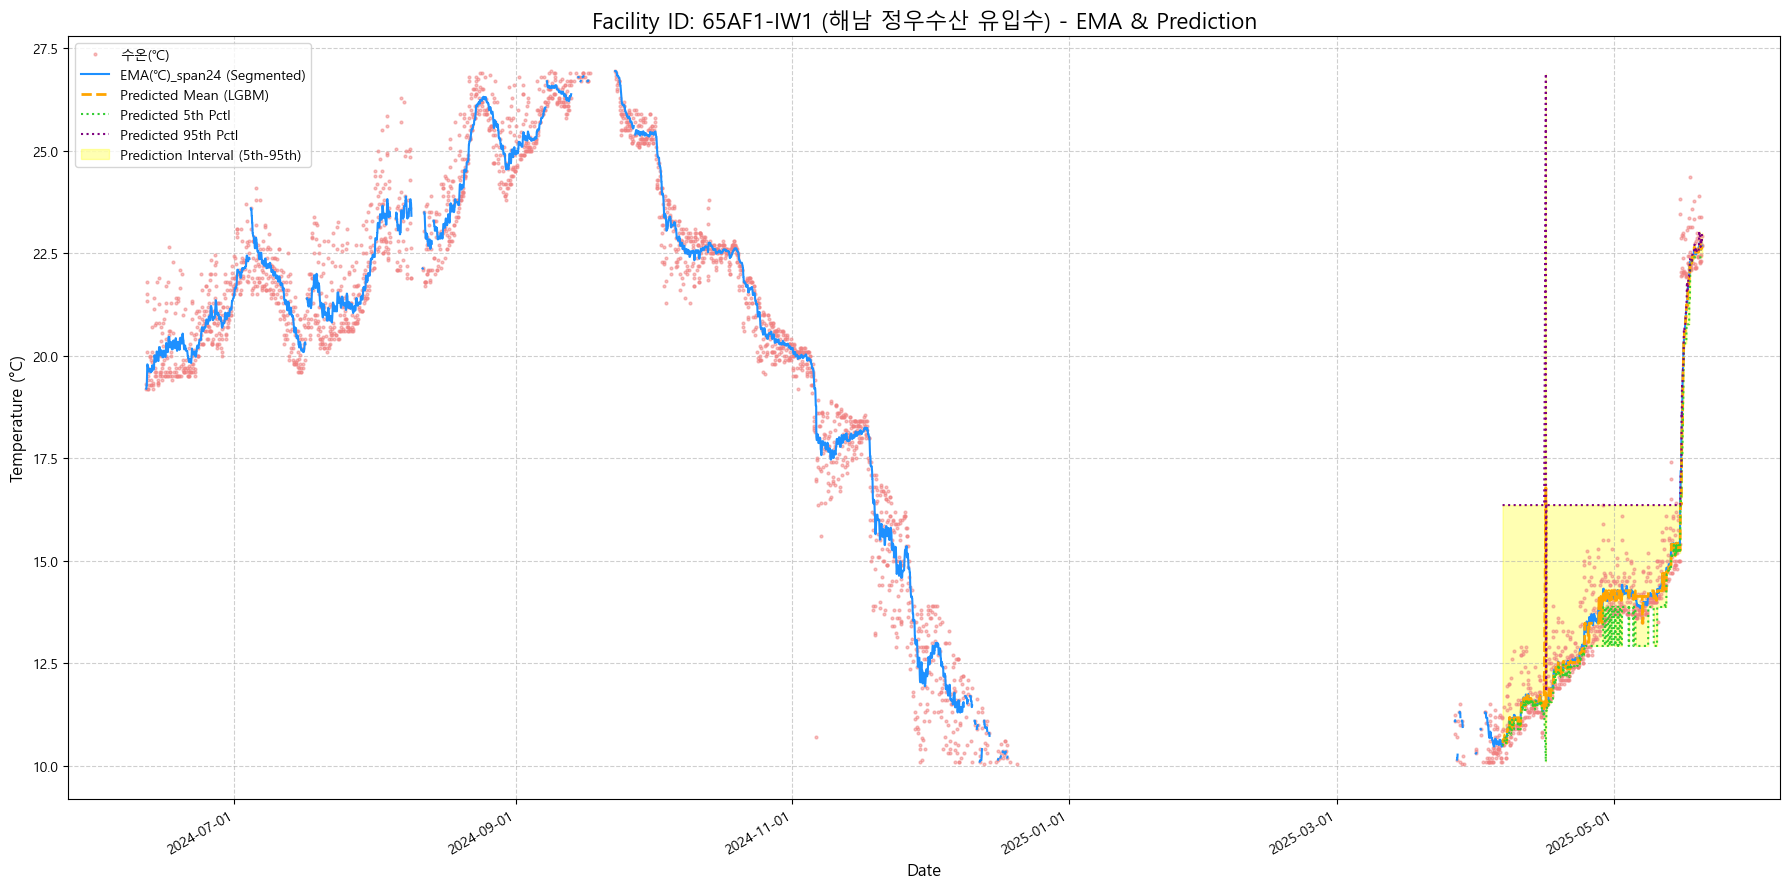


--- 제주 바다드림영어조합법인 유입수 (64AF2-IW1)의 데이터 처리 시작 ---
[64AF2-IW1] 학습 데이터: 14103, 테스트 데이터: 3526
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14103, number of used features: 7
[LightGBM] [Info] Start training from score 18.750274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 14103, number of used features: 7
[LightGBM] [Info] Start training from score 15.864151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


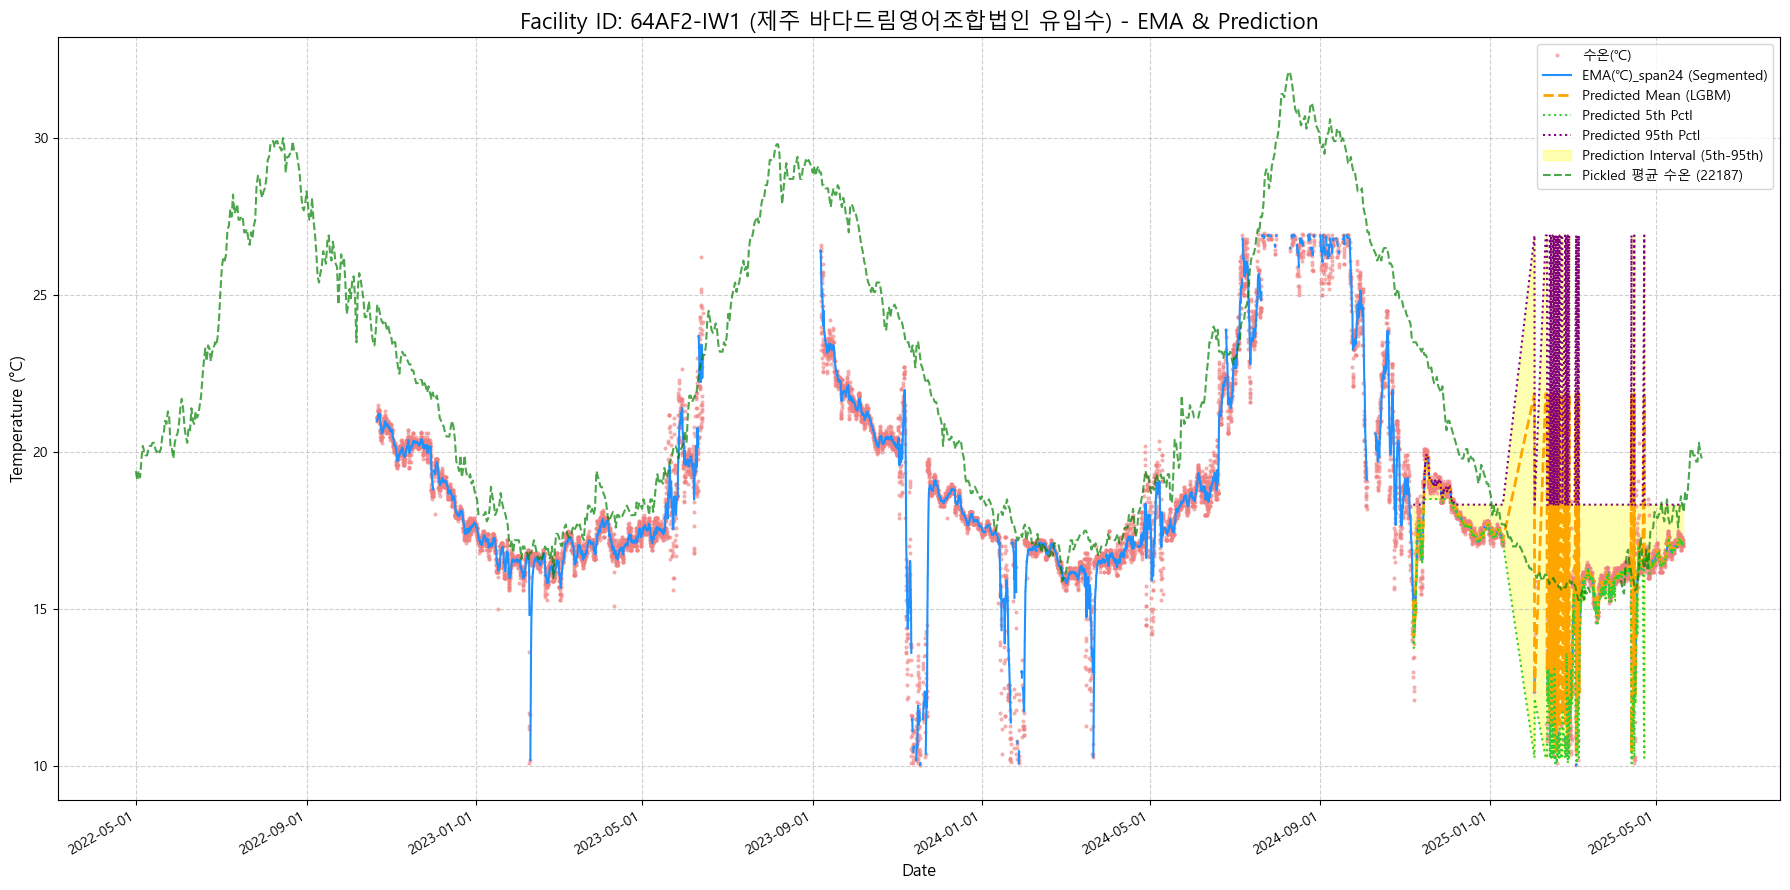


--- 제주 비봉수산 수조15 (64AF1-RT1)의 데이터 처리 시작 ---
[64AF1-RT1] 학습 데이터: 16979, 테스트 데이터: 4245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 16979, number of used features: 7
[LightGBM] [Info] Start training from score 19.628704
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 16979, number of used features: 7
[LightGBM] [Info] Start training from score 16.965328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

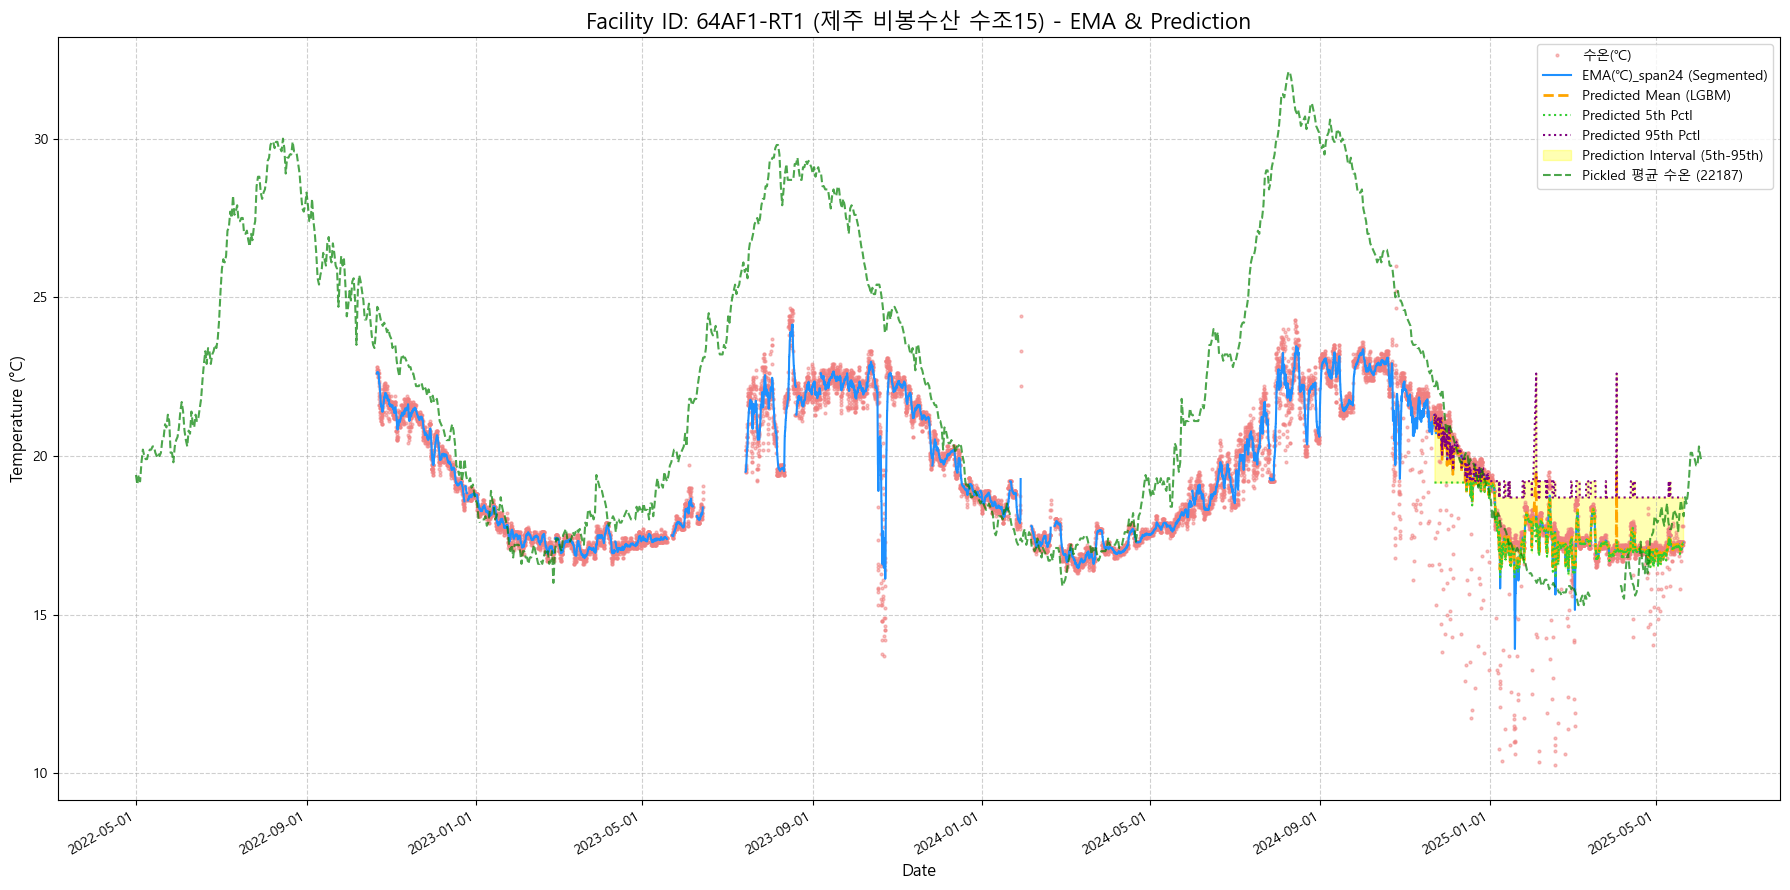


--- 제주 비봉수산 수조16 (64AF1-RT2)의 데이터 처리 시작 ---
[64AF1-RT2] 학습 데이터: 16613, 테스트 데이터: 4154
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 16613, number of used features: 7
[LightGBM] [Info] Start training from score 19.672903
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 16613, number of used features: 7
[LightGBM] [Info] Start training from score 17.002806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

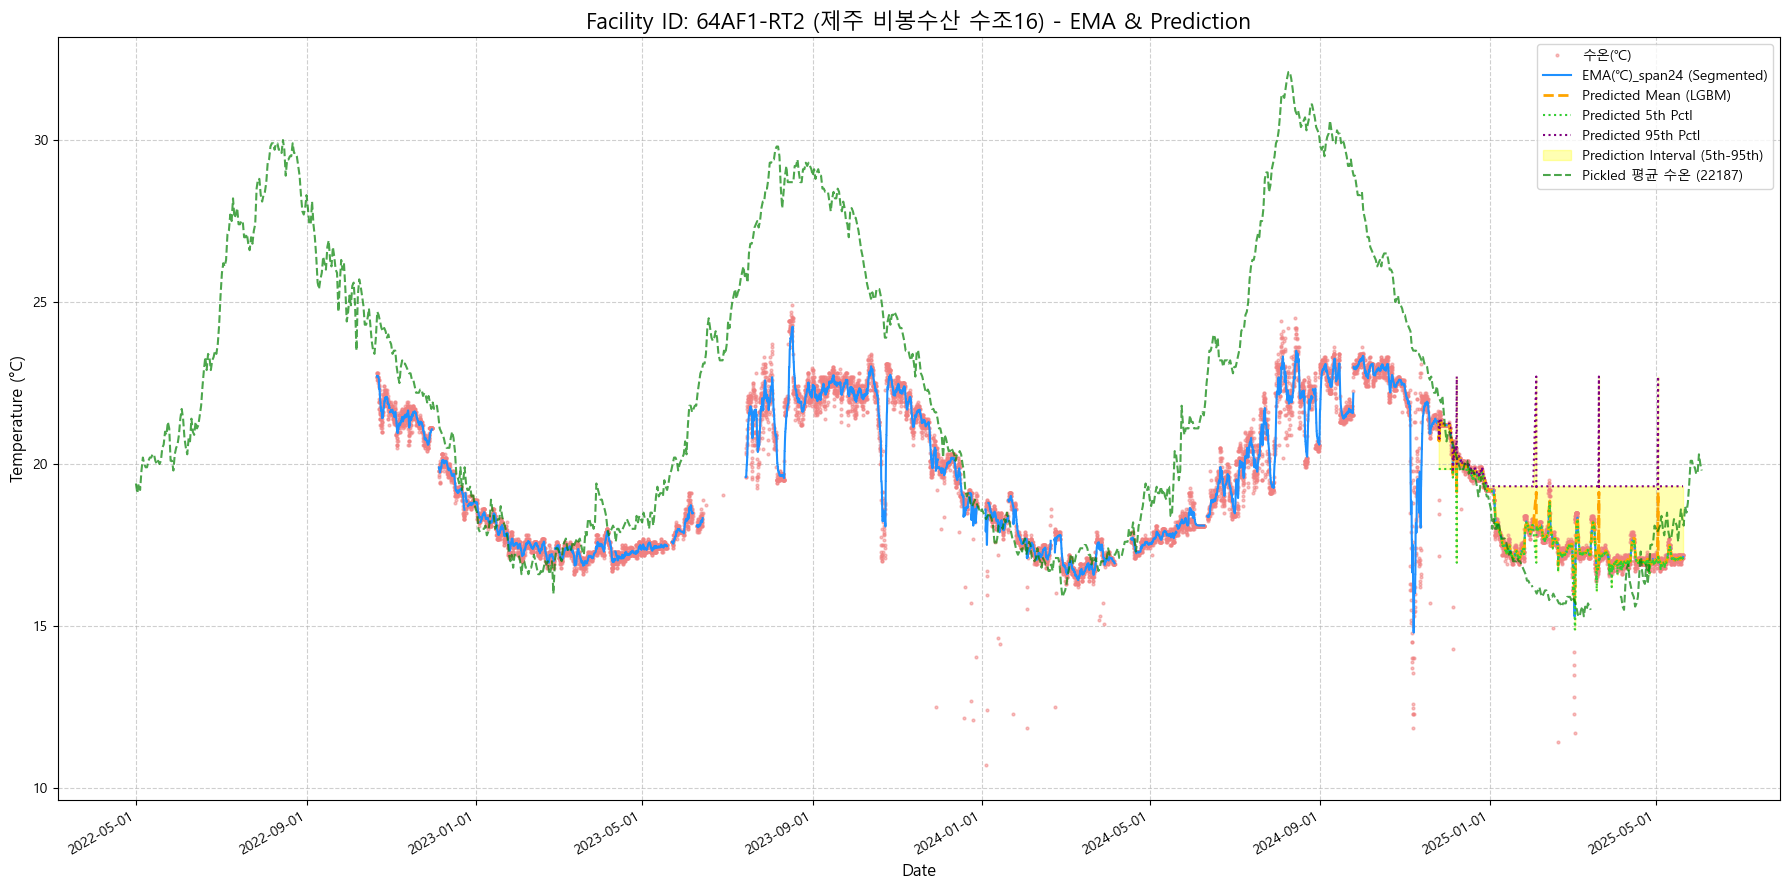


--- 해남 정우수산 수조1 (65AF1-RT1)의 데이터 처리 시작 ---
[65AF1-RT1] 학습 데이터: 4151, 테스트 데이터: 1038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4151, number of used features: 7
[LightGBM] [Info] Start training from score 20.788022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4151, number of used features: 7
[LightGBM] [Info] Start training from score 11.624029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

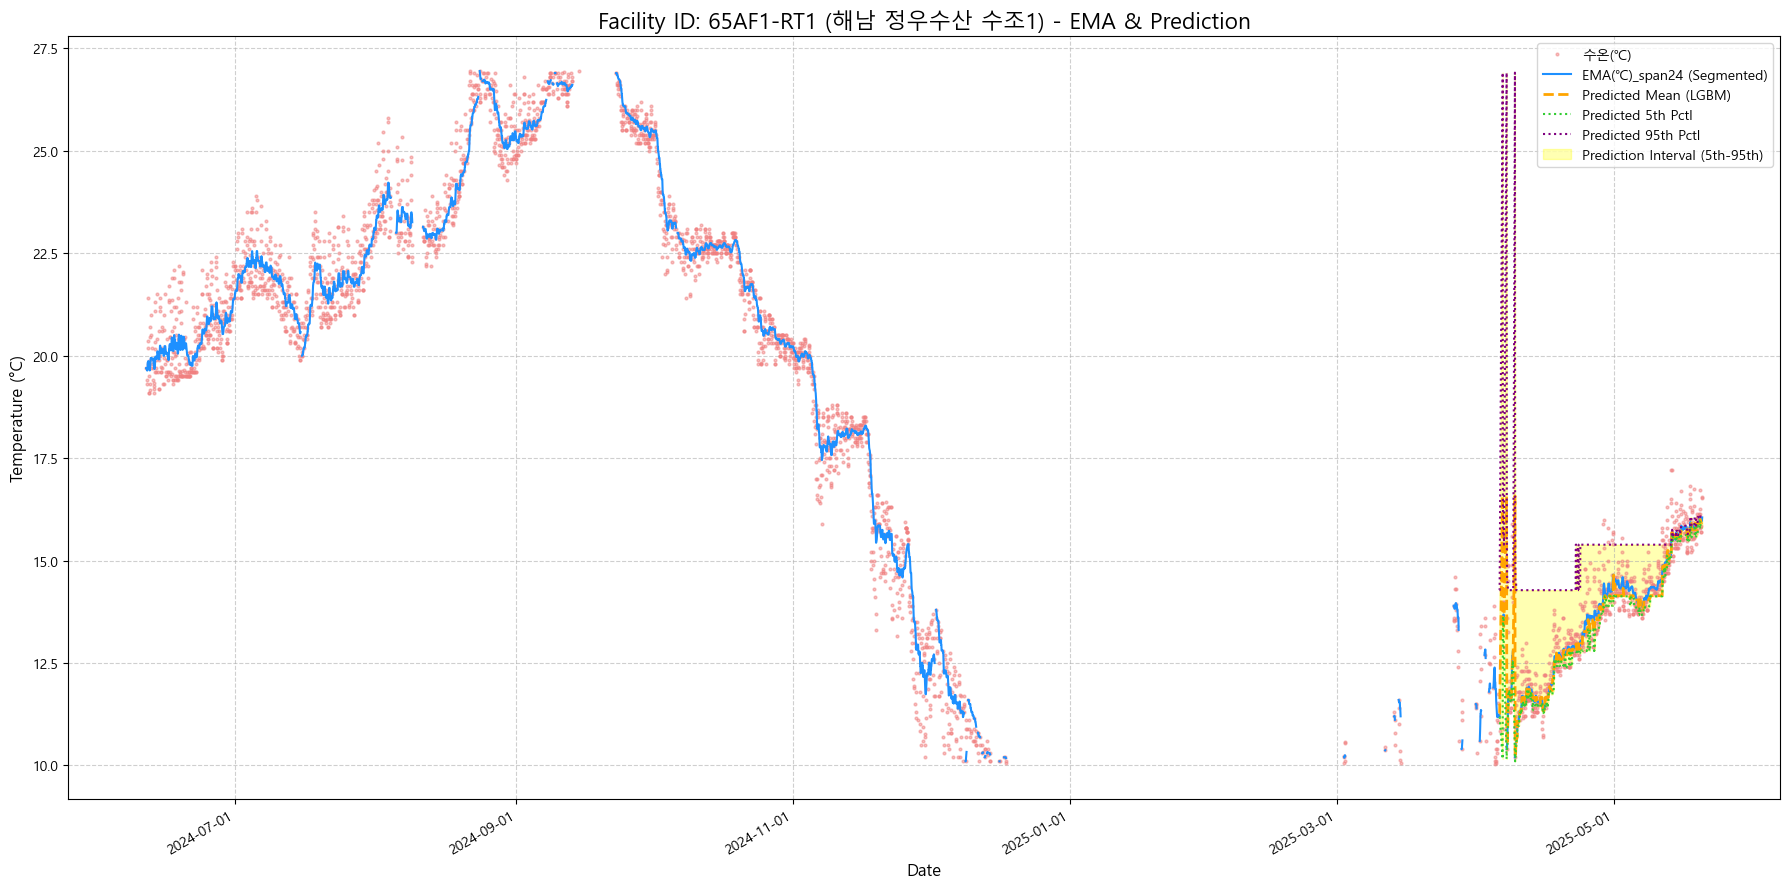


--- 완도 그린수산 유입수 (61AF1-IW1)의 데이터 처리 시작 ---
[61AF1-IW1] 학습 데이터: 8693, 테스트 데이터: 2174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 7
[LightGBM] [Info] Start training from score 16.624679
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 8693, number of used features: 7
[LightGBM] [Info] Start training from score 10.433389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

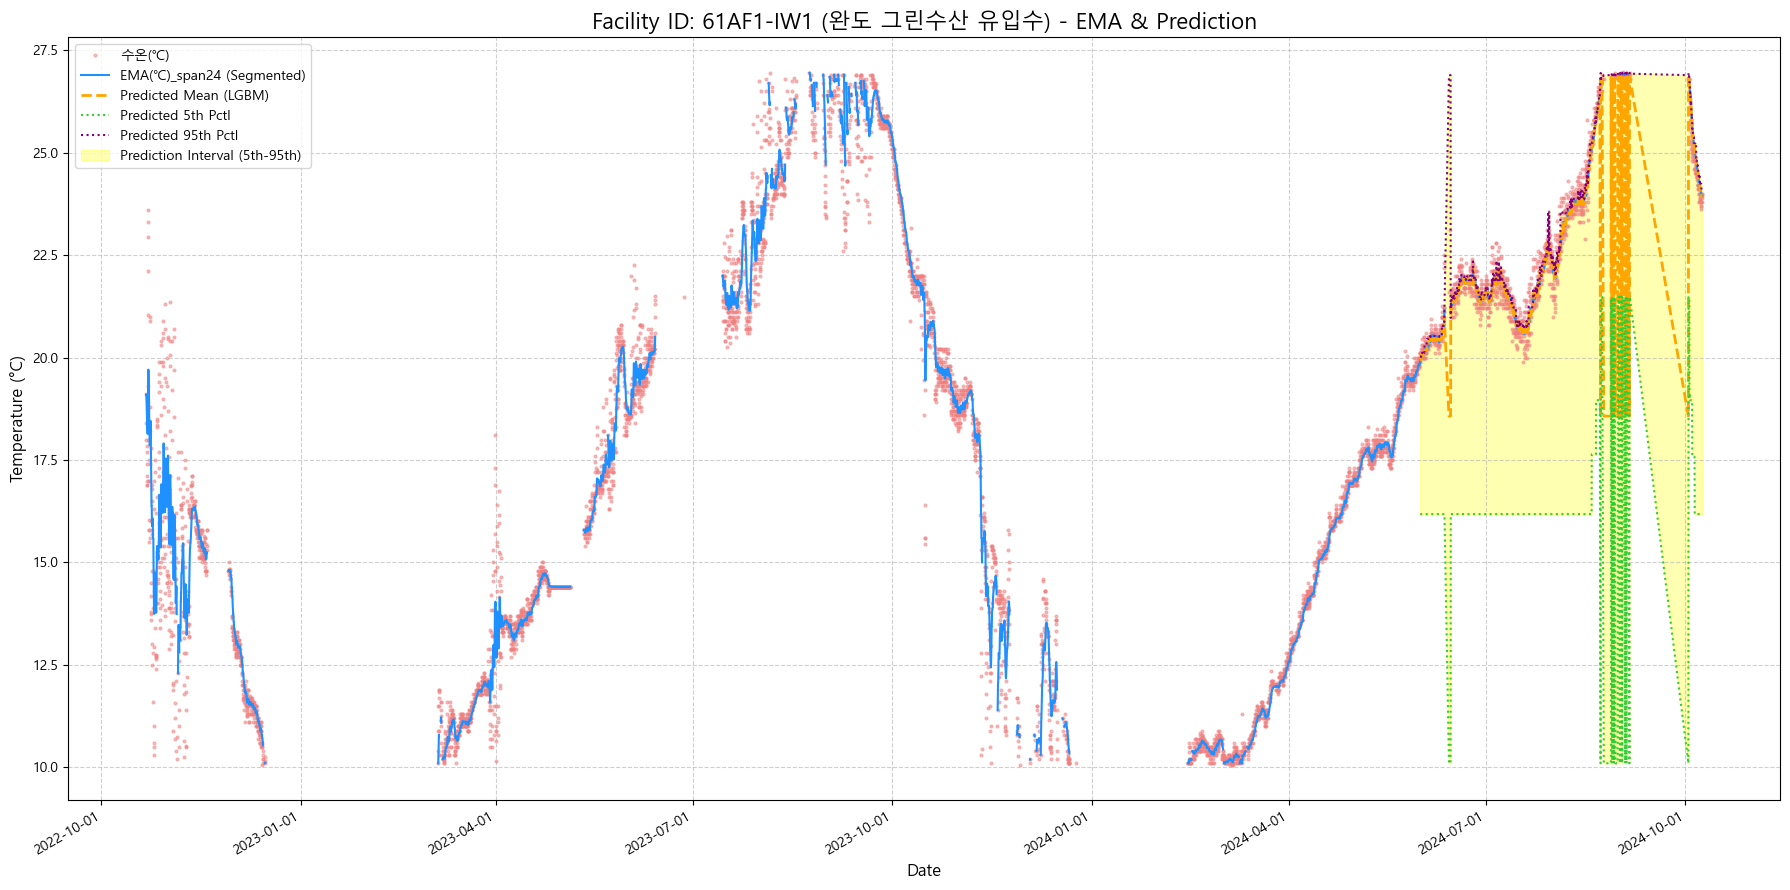


--- 완도 그린수산 수조F5 (61AF1-RT2)의 데이터 처리 시작 ---
[61AF1-RT2] 학습 데이터: 8621, 테스트 데이터: 2156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 7
[LightGBM] [Info] Start training from score 16.365971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 8621, number of used features: 7
[LightGBM] [Info] Start training from score 10.395600
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

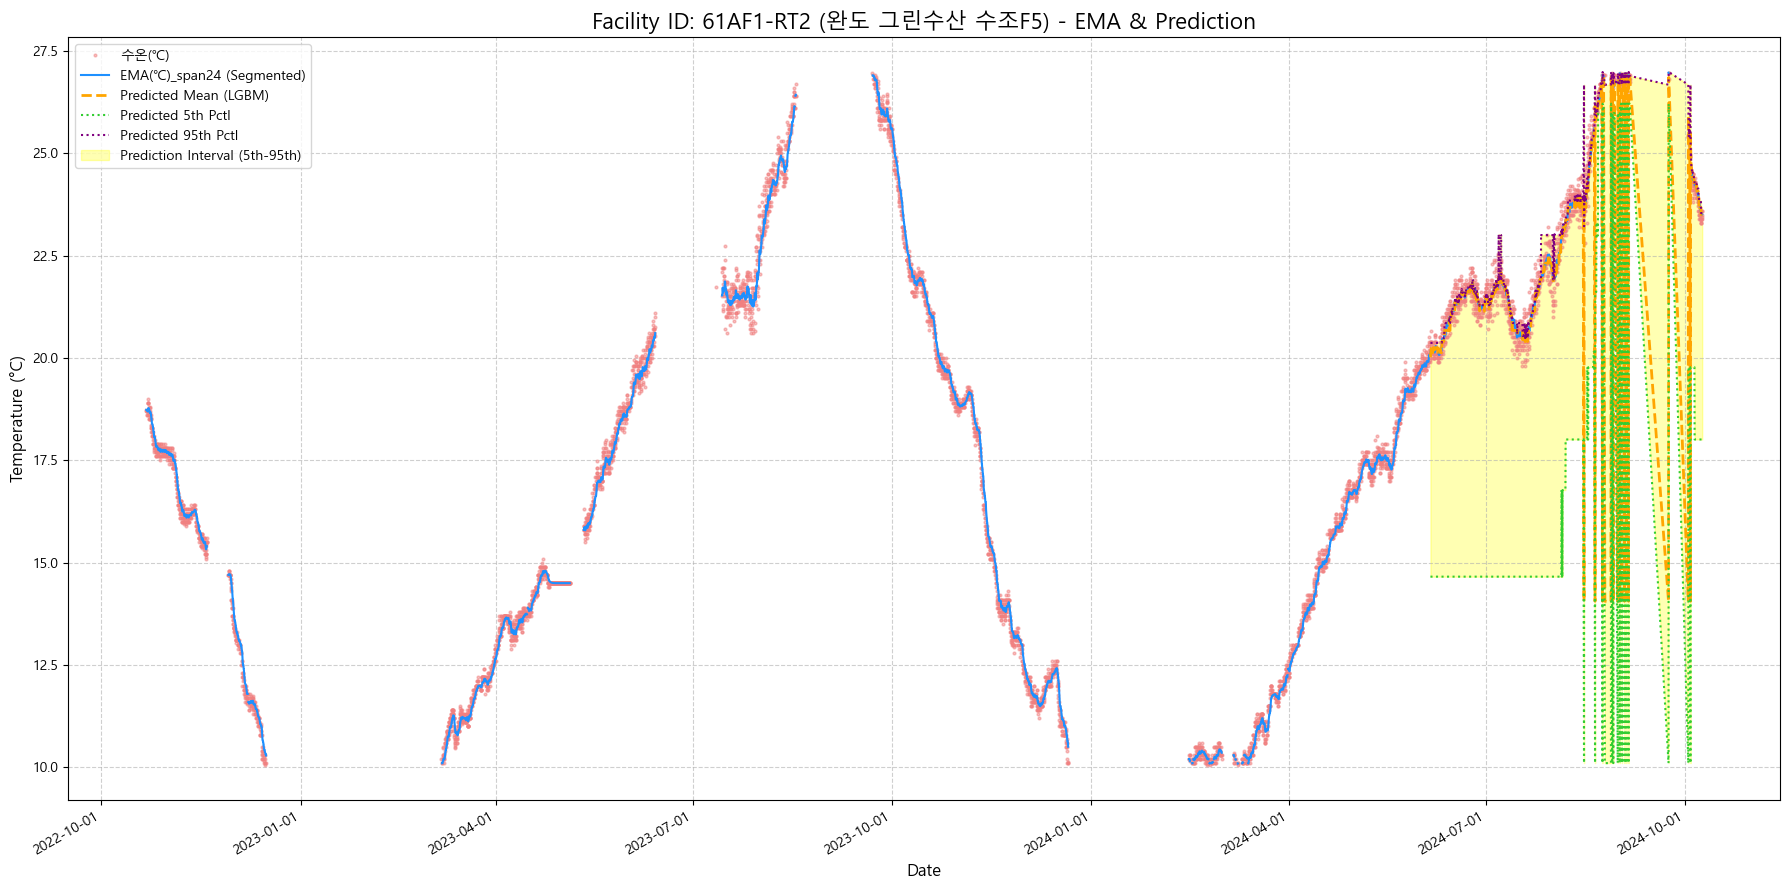


--- 완도 그린수산 수조A5 (61AF1-RT1)의 데이터 처리 시작 ---
[61AF1-RT1] 학습 데이터: 8816, 테스트 데이터: 2205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 8816, number of used features: 7
[LightGBM] [Info] Start training from score 16.293096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 8816, number of used features: 7
[LightGBM] [Info] Start training from score 10.413169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

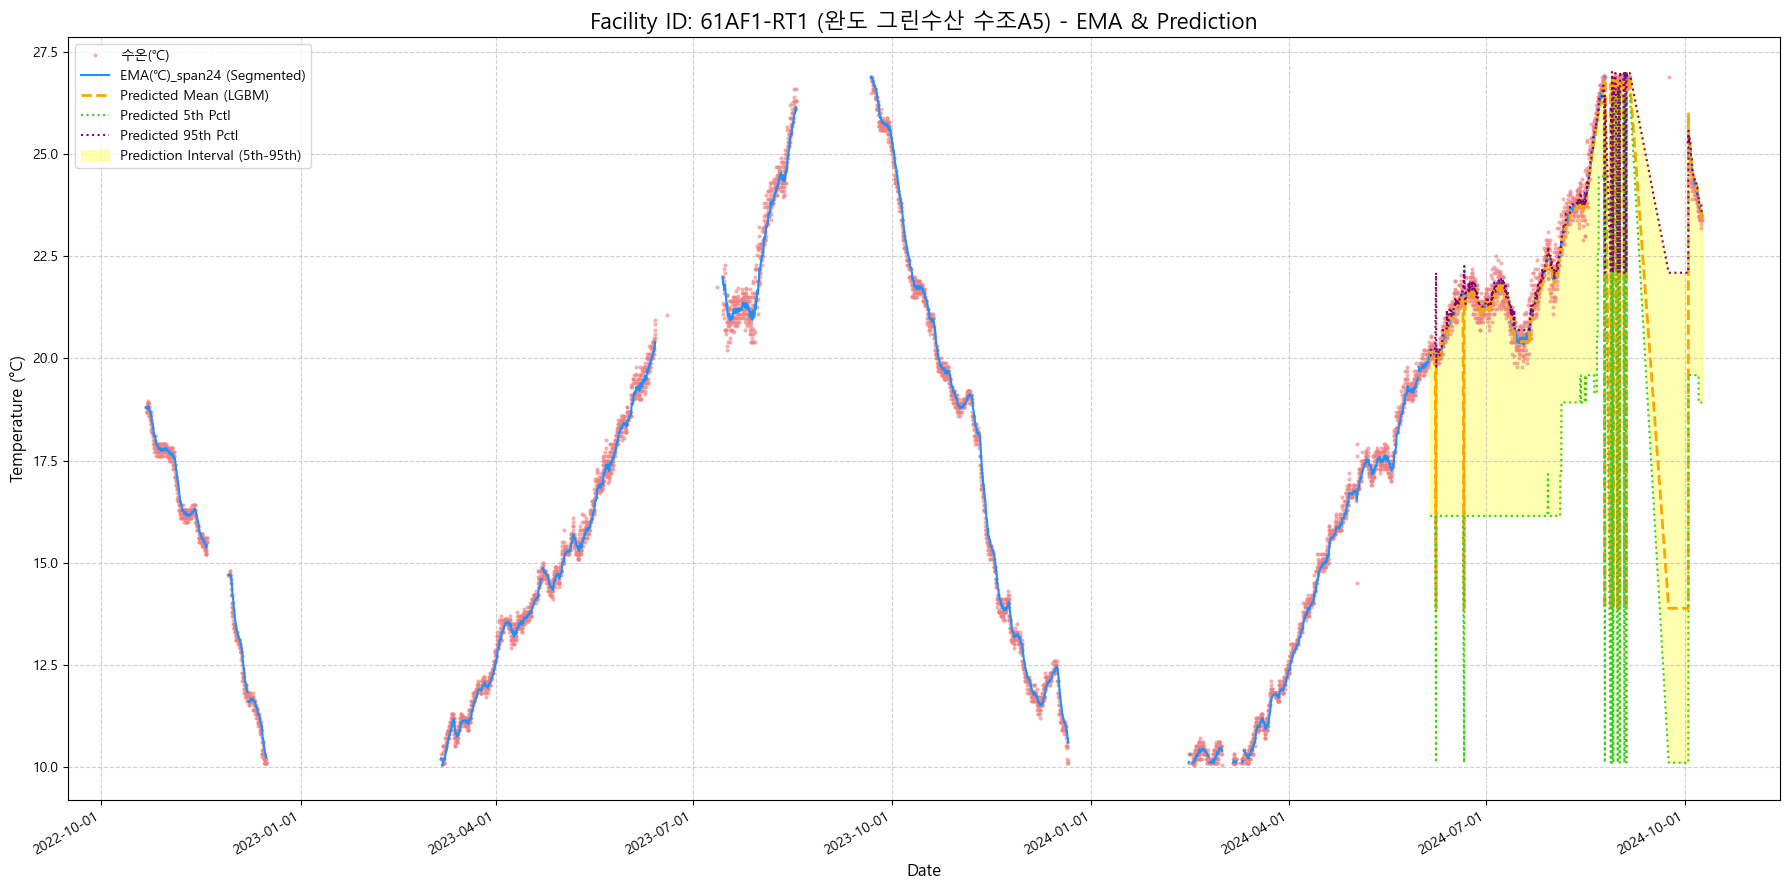


--- 모든 시설 처리 완료 ---


In [15]:
for fi in facility_id_dict.keys():
    farms_id_name = fi.split('-')[0]
    farms_temp_trigger = False
    from_pickles_filtered = None # 각 fi 루프 시작 시 초기화

    if farms_id_name in jeju_water_farms and df_from_pickle is not None:
        farms_temp_trigger = True
        from_pickles_filtered = df_from_pickle[df_from_pickle['지점'] == jeju_water_farms[farms_id_name]].copy()
        if not pd.api.types.is_datetime64_any_dtype(from_pickles_filtered['일시']):
             from_pickles_filtered['일시'] = pd.to_datetime(from_pickles_filtered['일시'])

    print(f"\n--- {facility_id_dict[fi]} ({fi})의 데이터 처리 시작 ---")
    target_df = sampled_df[sampled_df['시설 ID'] == fi].copy()
    if not pd.api.types.is_datetime64_any_dtype(target_df['일시']):
        target_df['일시'] = pd.to_datetime(target_df['일시'])
    target_df = target_df.sort_values(by='일시').reset_index(drop=True)

    if median_filtered_column_name not in target_df.columns:
        print(f"'{median_filtered_column_name}' 컬럼이 target_df '{fi}'에 없습니다. 다음 시설로 넘어갑니다.")
        continue
    if target_df[median_filtered_column_name].isnull().all():
        print(f"'{median_filtered_column_name}' 컬럼의 모든 값이 NaN입니다. 다음 시설로 넘어갑니다.")
        continue
        
    # --- 1. (기존) 긴 NaN 구간을 기준으로 데이터 분할 준비 ---
    target_df['is_na'] = target_df[median_filtered_column_name].isna()
    target_df['na_block_id'] = (target_df['is_na'] != target_df['is_na'].shift()).cumsum()
    target_df['na_block_size'] = target_df.groupby('na_block_id')['is_na'].transform('size')
    target_df['is_long_nan_divider'] = target_df['is_na'] & (target_df['na_block_size'] >= nan_stretch_threshold)
    target_df['segment_group'] = (target_df['is_long_nan_divider'] != target_df['is_long_nan_divider'].shift()).cumsum()

    ema_column_name = f'EMA(℃)_span{ema_span}'
    target_df[ema_column_name] = np.nan

    # --- 2. (기존) 각 데이터 세그먼트별 EMA 계산 ---
    for G_idx, group_df in target_df.groupby('segment_group'):
        if group_df['is_long_nan_divider'].all():
            continue
        else:
            data_series_for_ema = group_df[median_filtered_column_name]
            if data_series_for_ema.notna().sum() >= 1:
                segment_ema_values = data_series_for_ema.ewm(span=ema_span, adjust=False, min_periods=1, ignore_na=False).mean()
                target_df.loc[segment_ema_values.index, ema_column_name] = segment_ema_values
    
    if target_df[ema_column_name].isnull().all():
        print(f"EMA 계산 후 '{ema_column_name}' 컬럼의 모든 값이 NaN입니다. 예측을 진행할 수 없습니다.")
    else:
        # --- 3. [추가] LightGBM을 이용한 예측 ---
        # EMA 값을 타겟으로 사용
        prediction_target_col = ema_column_name
        
        # Lagged features 생성 (EMA 값 기준)
        df_for_prediction = create_lagged_features_for_prediction(target_df[['일시', prediction_target_col]], 
                                                                  prediction_target_col, 
                                                                  prediction_lags)
        
        # 예측에 사용할 최종 데이터 (타겟이 NaN이거나, 특성 생성 시 초기에 NaN이 된 행 제외)
        # LightGBM은 특성(X)의 NaN은 처리 가능하나, 타겟(y)의 NaN은 학습에 사용할 수 없음
        df_for_prediction = df_for_prediction.dropna(subset=[prediction_target_col]) # 타겟이 NaN인 행 제거
        
        # 특성(X)과 타겟(y) 분리
        # dropna(axis=1, how='all') # 모든 값이 NaN인 lag 컬럼 제거 (데이터가 너무 적을 경우 발생 가능)
        # 여기서는 lag 생성 시 모든 값이 NaN인 컬럼이 나올 수 있으므로, 안전하게 처리
        # X = df_for_prediction.drop(columns=['일시', prediction_target_col]).dropna(axis=1, how='all')
        
        feature_columns = [col for col in df_for_prediction.columns if f'{prediction_target_col}_lag_' in col]
        if not feature_columns: # 생성된 lag 특성이 없는 경우
            print(f"[{fi}] Lag 특성을 생성할 충분한 데이터가 없습니다. 예측을 건너<0xEB><0xA9><0x99>니다.")
            # 이 경우, 예측 없이 기존 그래프만 그림
            y_pred_mean_series = pd.Series(index=target_df.index, dtype='float64')
            y_pred_lower_series = pd.Series(index=target_df.index, dtype='float64')
            y_pred_upper_series = pd.Series(index=target_df.index, dtype='float64')

        else:
            X = df_for_prediction[feature_columns]
            y = df_for_prediction[prediction_target_col]
            
            # 데이터가 충분한지 확인
            if len(X) < max(prediction_lags) + predict_ahead_steps + 10: # 최소 데이터 수 (임의로 설정)
                print(f"[{fi}] 모델 학습에 충분한 데이터가 없습니다 ({len(X)}개). 예측을 건너<0xEB><0xA9><0x99>니다.")
                y_pred_mean_series = pd.Series(index=target_df.index, dtype='float64')
                y_pred_lower_series = pd.Series(index=target_df.index, dtype='float64')
                y_pred_upper_series = pd.Series(index=target_df.index, dtype='float64')
            else:
                # 시계열 데이터 분리 (시간 순서 유지)
                # 주의: df_for_prediction의 인덱스는 target_df의 인덱스와 일치할 수 있도록 관리
                train_indices, test_indices = train_test_split(X.index, test_size=test_size_ratio, shuffle=False)

                X_train, X_test = X.loc[train_indices], X.loc[test_indices]
                y_train, y_test = y.loc[train_indices], y.loc[test_indices]

                print(f"[{fi}] 학습 데이터: {len(X_train)}, 테스트 데이터: {len(X_test)}")

                # LightGBM 모델 학습 (평균 예측)
                lgbm_reg = lgb.LGBMRegressor(random_state=42)
                lgbm_reg.fit(X_train, y_train)
                y_pred_mean_test = lgbm_reg.predict(X_test)

                # 분위수 회귀 (하한, 상한)
                lgbm_quantile_lower = lgb.LGBMRegressor(objective='quantile', alpha=0.05, random_state=42) # 5%
                lgbm_quantile_lower.fit(X_train, y_train)
                y_pred_lower_test = lgbm_quantile_lower.predict(X_test)

                lgbm_quantile_upper = lgb.LGBMRegressor(objective='quantile', alpha=0.95, random_state=42) # 95%
                lgbm_quantile_upper.fit(X_train, y_train)
                y_pred_upper_test = lgbm_quantile_upper.predict(X_test)
                
                # 예측 결과를 원래 target_df의 인덱스에 맞게 Series로 변환
                y_pred_mean_series = pd.Series(y_pred_mean_test, index=y_test.index)
                y_pred_lower_series = pd.Series(y_pred_lower_test, index=y_test.index)
                y_pred_upper_series = pd.Series(y_pred_upper_test, index=y_test.index)


    # --- 4. (기존 + 수정) 결과 시각화 ---
    plt.figure(figsize=(18, 9)) # 그래프 크기 조정
    if median_filtered_column_name in target_df.columns:
        plt.plot(target_df['일시'], target_df[median_filtered_column_name], label=median_filtered_column_name, marker='.', linestyle='None', color='lightcoral', alpha=0.5, markersize=4)
    else:
        print(f"경고: 컬럼 '{median_filtered_column_name}'을 찾을 수 없습니다.")

    plt.plot(target_df['일시'], target_df[ema_column_name], label=f'{ema_column_name} (Segmented)', linestyle='-', color='dodgerblue', linewidth=1.5)

    # 예측 결과 플로팅 (테스트 구간에 대해서만)
    if 'y_pred_mean_series' in locals() and not y_pred_mean_series.empty: # 예측이 수행된 경우
        plt.plot(target_df['일시'].loc[y_pred_mean_series.index], y_pred_mean_series, label='Predicted Mean (LGBM)', color='orange', linestyle='--', linewidth=2)
        plt.plot(target_df['일시'].loc[y_pred_lower_series.index], y_pred_lower_series, label='Predicted 5th Pctl', color='limegreen', linestyle=':', linewidth=1.5)
        plt.plot(target_df['일시'].loc[y_pred_upper_series.index], y_pred_upper_series, label='Predicted 95th Pctl', color='purple', linestyle=':', linewidth=1.5)
        plt.fill_between(target_df['일시'].loc[y_pred_lower_series.index], 
                         y_pred_lower_series, y_pred_upper_series, 
                         color='yellow', alpha=0.3, label='Prediction Interval (5th-95th)')


    if farms_temp_trigger and from_pickles_filtered is not None:
        if '일시' in from_pickles_filtered.columns and '평균 수온(°C)' in from_pickles_filtered.columns and not from_pickles_filtered.empty:
            plt.plot(from_pickles_filtered['일시'], from_pickles_filtered['평균 수온(°C)'], label=f'Pickled 평균 수온 ({jeju_water_farms.get(farms_id_name,"")})', linestyle='--', color='green', alpha=0.7)
        elif not from_pickles_filtered.empty :
             print(f"경고 ({fi}): Pickle DataFrame에 '일시' 또는 '평균 수온(°C)' 컬럼이 없거나 데이터가 없어 그래프에 표시하지 않습니다.")


    plt.title(f'Facility ID: {fi} ({facility_id_dict[fi]}) - EMA & Prediction', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # 날짜 포맷 변경 (필요시 %H:%M 추가)
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    # 저장 경로 확인 및 필요시 생성
    # import os
    # if not os.path.exists('./figures'):
    #     os.makedirs('./figures')
    plt.savefig(f'./figures/EMA_Segmented_Prediction_{fi.replace("/","_")}.png', dpi=300) # 파일명에 /가 있으면 오류나므로 변경
    plt.show() # 주피터 노트북 등에서 바로 확인하려면 추가
    plt.close() # 메모리 관리를 위해 추가

print("\n--- 모든 시설 처리 완료 ---")